In [1]:
import os
import time
import random
import argparse
import pickle
import numpy as np
from tqdm import tqdm
from os.path import join

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.backends import cudnn
from torch.utils.tensorboard import SummaryWriter

import metric
from utils import collate_fn
from narm import NARM
from dataset import load_data, RecSysDataset

writer = SummaryWriter()

parser = argparse.ArgumentParser()

parser.add_argument('--dataset_path', default='amex_explorepoi-poi_category')
parser.add_argument('--batch_size', type=int, default=512, help='input batch size')
parser.add_argument('--hidden_size', type=int, default=100, help='hidden state size of gru module')
parser.add_argument('--embed_dim', type=int, default=50, help='the dimension of item embedding')
parser.add_argument('--epoch', type=int, default=100, help='the number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')  
parser.add_argument('--lr_dc', type=float, default=0.1, help='learning rate decay rate')
parser.add_argument('--lr_dc_step', type=int, default=80, help='the number of steps after which the learning rate decay') 
parser.add_argument('--test', action='store_true', help='test')
parser.add_argument('--topk', type=int, default=20, help='number of top score items selected for calculating recall and mrr metrics')
parser.add_argument('--valid_portion', type=float, default=0.1, help='split the portion of training set as validation set')
args,_ = parser.parse_known_args()
print(args)

amex_sets = set(['amex_explorepoi-poi_category', 'amex_explorepoi-poi_context', 'amex_explorepoi-category', 'amex_explorepoi-context', 'amex_log-poi', 'amex_log-category', 'amex_log-context'])

other_sets = set(['amex_poi'])

/home/ec2-user/anaconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(batch_size=512, dataset_path='amex_explorepoi-poi_category', embed_dim=50, epoch=100, hidden_size=100, lr=0.001, lr_dc=0.1, lr_dc_step=80, test=False, topk=20, valid_portion=0.1)


In [2]:
def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
dataset_loc="/home/ec2-user/SageMaker/sequence-based-recommendation/NARM/datasets/"
args.dataset_path = dataset_loc + args.dataset_path + '/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print('Loading data...')

train, valid, test = load_data(args.dataset_path, valid_portion=args.valid_portion)

train_data = RecSysDataset(train)
valid_data = RecSysDataset(valid)
test_data = RecSysDataset(test)
train_loader = DataLoader(train_data, batch_size = args.batch_size, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_data, batch_size = args.batch_size, shuffle = False, collate_fn = collate_fn)
test_loader = DataLoader(test_data, batch_size = args.batch_size, shuffle = False, collate_fn = collate_fn)

Loading data...
--------------------------------------------------
Dataset info:
Number of sessions: 3182
--------------------------------------------------
--------------------------------------------------
Dataset info:
Number of sessions: 354
--------------------------------------------------
--------------------------------------------------
Dataset info:
Number of sessions: 305
--------------------------------------------------


In [5]:
args.dataset_path.split('/')

['',
 'home',
 'ec2-user',
 'SageMaker',
 'sequence-based-recommendation',
 'NARM',
 'datasets',
 'amex_explorepoi-poi_category',
 '']

In [6]:
dataset_name = args.dataset_path.split('/')[-2] 

In [7]:
if args.dataset_path.split('/')[-2] in ['amex_explorepoi-poi_category', 'amex_explorepoi-poi_context']:
    n_items = 556 #line 182 print(item_ctr) in preprocess.py

In [8]:
model = NARM(n_items, args.hidden_size, args.embed_dim, args.batch_size).to(device)

In [9]:
print("{:<30}{:<20,}".format("Number of parameters",np.sum([p.nelement() for p in model.parameters()])))

Number of parameters          103,500             


In [14]:
def trainForEpoch(train_loader, model, optimizer, epoch, num_epochs, criterion, log_aggr=10):
    model.train()

    sum_epoch_loss = 0

    start = time.time()
    for i, (seq, target, lens) in tqdm(enumerate(train_loader), total=len(train_loader)):
        seq = seq.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        outputs = model(seq, lens)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step() 
        
        loss_val = loss.item()
        sum_epoch_loss += loss_val

        iter_num = epoch * len(train_loader) + i + 1
        
        writer.add_scalar("Loss/train", loss, iter_num)

        if i%(len(train_loader)//log_aggr) == 0 and not i==0:
            print('[TRAIN] epoch %d/%d batch loss: %.4f (avg %.4f) (%.2f im/s)'
                % (epoch + 1, num_epochs, loss_val, sum_epoch_loss / (i + 1),
                  len(seq) / (time.time() - start)))

        start = time.time()


def validate(valid_loader, model,criterion):
    model.eval()
    recalls = []
    mrrs = []
    losses=[]
    with torch.no_grad():
        for seq, target, lens in valid_loader:
            seq = seq.to(device)
            target = target.to(device)
            outputs = model(seq, lens)
            loss = criterion(outputs, target)
            logits = F.softmax(outputs, dim = 1)
            recall, mrr = metric.evaluate(logits, target, k = args.topk)
            recalls.append(recall)
            mrrs.append(mrr)
            losses.append(loss.item())
    
    mean_recall = np.mean(recalls)
    mean_mrr = np.mean(mrrs)
    mean_loss=np.mean(losses)
    
    return mean_recall, mean_mrr, mean_loss


In [15]:
optimizer = optim.Adam(model.parameters(), args.lr)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size = args.lr_dc_step, gamma = args.lr_dc)

best_metric = float('inf')

TRAIN_LOSS=[]
VALID_LOSS=[]
TEST_LOSS=[]

TRAIN_MRR=[]
VALID_MRR=[]
TEST_MRR=[]

TRAIN_RECALL=[]
VALID_RECALL=[]
TEST_RECALL=[]

for epoch in tqdm(range(args.epoch)): #before: no leave param, now , leave=False
#         time.sleep(1)
    # train for one epoch
    scheduler.step(epoch = epoch)
    trainForEpoch(train_loader, model, optimizer, epoch, args.epoch, criterion, log_aggr = 5)

    train_recall, train_mrr, train_loss = validate(train_loader, model, criterion)
    TRAIN_LOSS.append(train_loss)
    TRAIN_MRR.append(train_mrr)
    TRAIN_RECALL.append(train_recall)
    print()
    print('Epoch {} training-- loss: {:.4f}, Recall@{}: {:.4f}, MRR@{}: {:.4f} \n'.format(epoch, train_loss,args.topk, train_recall, args.topk, train_mrr))
    
    valid_recall, valid_mrr, valid_loss = validate(valid_loader, model, criterion)
    VALID_LOSS.append(valid_loss)
    VALID_MRR.append(valid_mrr)
    VALID_RECALL.append(valid_recall)
    print('Epoch {} validation-- loss: {:.4f}, Recall@{}: {:.4f}, MRR@{}: {:.4f} \n'.format(epoch, valid_loss,args.topk, valid_recall, args.topk, valid_mrr))
    
    test_recall, test_mrr, test_loss = validate(test_loader, model, criterion)
    TEST_LOSS.append(test_loss)
    TEST_MRR.append(test_mrr)
    TEST_RECALL.append(test_recall)
    print('Epoch {} test-- loss: {:.4f}, Recall@{}: {:.4f}, MRR@{}: {:.4f} \n'.format(epoch, test_loss,args.topk, test_recall, args.topk, test_mrr))
    
    writer.add_scalar("Recall/train", test_recall, epoch)
    
    # store best loss and save a model checkpoint
    ckpt_dict = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    
    selected_metric=test_loss
    if selected_metric<best_metric:
        best_metric=selected_metric
        torch.save(ckpt_dict, dataset_name + '_' + 'latest_checkpoint.pth')
    writer.flush()

  1%|          | 1/100 [00:00<00:11,  8.33it/s]

[TRAIN] epoch 1/100 batch loss: 2.3609 (avg 2.1705) (1840.84 im/s)
[TRAIN] epoch 1/100 batch loss: 2.2105 (avg 2.1839) (1860.57 im/s)
[TRAIN] epoch 1/100 batch loss: 2.2086 (avg 2.1900) (1895.84 im/s)
[TRAIN] epoch 1/100 batch loss: 2.1912 (avg 2.1903) (1872.33 im/s)
[TRAIN] epoch 1/100 batch loss: 2.0855 (avg 2.1728) (1855.80 im/s)
[TRAIN] epoch 1/100 batch loss: 2.3551 (avg 2.1988) (2867.02 im/s)

Epoch 0 training-- loss: 1.5597, Recall@20: 0.9486, MRR@20: 0.7571 

Epoch 0 validation-- loss: 3.5534, Recall@20: 0.7542, MRR@20: 0.5860 

Epoch 0 test-- loss: 4.4981, Recall@20: 0.6689, MRR@20: 0.5072 




100%|██████████| 7/7 [00:00<00:00, 102.09it/s]


[TRAIN] epoch 2/100 batch loss: 2.1046 (avg 2.0545) (1846.51 im/s)
[TRAIN] epoch 2/100 batch loss: 2.3254 (avg 2.1448) (1896.79 im/s)
[TRAIN] epoch 2/100 batch loss: 2.1741 (avg 2.1521) (1894.27 im/s)
[TRAIN] epoch 2/100 batch loss: 2.1604 (avg 2.1538) (1881.03 im/s)
[TRAIN] epoch 2/100 batch loss: 2.1949 (avg 2.1606) (1849.90 im/s)
[TRAIN] epoch 2/100 batch loss: 1.9540 (avg 2.1311) (2861.88 im/s)


  2%|▏         | 2/100 [00:00<00:11,  8.36it/s]


Epoch 1 training-- loss: 1.5416, Recall@20: 0.9440, MRR@20: 0.7602 

Epoch 1 validation-- loss: 3.3994, Recall@20: 0.7486, MRR@20: 0.5959 

Epoch 1 test-- loss: 4.1694, Recall@20: 0.6754, MRR@20: 0.5308 




100%|██████████| 7/7 [00:00<00:00, 99.76it/s]


[TRAIN] epoch 3/100 batch loss: 2.2048 (avg 2.1048) (1784.41 im/s)
[TRAIN] epoch 3/100 batch loss: 2.1470 (avg 2.1188) (1893.37 im/s)
[TRAIN] epoch 3/100 batch loss: 2.0382 (avg 2.0987) (1701.03 im/s)
[TRAIN] epoch 3/100 batch loss: 2.0202 (avg 2.0830) (1873.65 im/s)
[TRAIN] epoch 3/100 batch loss: 2.0891 (avg 2.0840) (1899.55 im/s)
[TRAIN] epoch 3/100 batch loss: 1.9712 (avg 2.0679) (2854.29 im/s)


  3%|▎         | 3/100 [00:00<00:11,  8.44it/s]


Epoch 2 training-- loss: 1.5073, Recall@20: 0.9534, MRR@20: 0.7642 

Epoch 2 validation-- loss: 3.5091, Recall@20: 0.7514, MRR@20: 0.5882 

Epoch 2 test-- loss: 4.2387, Recall@20: 0.6754, MRR@20: 0.5190 




100%|██████████| 7/7 [00:00<00:00, 103.26it/s]

[TRAIN] epoch 4/100 batch loss: 2.3245 (avg 2.2605) (1881.79 im/s)
[TRAIN] epoch 4/100 batch loss: 2.0111 (avg 2.1774) (1916.59 im/s)
[TRAIN] epoch 4/100 batch loss: 2.1425 (avg 2.1687) (1844.72 im/s)
[TRAIN] epoch 4/100 batch loss: 2.1962 (avg 2.1742) (1868.68 im/s)
[TRAIN] epoch 4/100 batch loss: 2.1301 (avg 2.1668) (1878.95 im/s)
[TRAIN] epoch 4/100 batch loss: 1.7758 (avg 2.1110) (2946.53 im/s)



  4%|▍         | 4/100 [00:00<00:11,  8.50it/s]


Epoch 3 training-- loss: 1.5675, Recall@20: 0.9518, MRR@20: 0.7554 

Epoch 3 validation-- loss: 3.5777, Recall@20: 0.7486, MRR@20: 0.5881 

Epoch 3 test-- loss: 4.4262, Recall@20: 0.6656, MRR@20: 0.5080 




100%|██████████| 7/7 [00:00<00:00, 102.87it/s]

[TRAIN] epoch 5/100 batch loss: 2.0908 (avg 2.0920) (1846.60 im/s)
[TRAIN] epoch 5/100 batch loss: 2.0598 (avg 2.0812) (1924.92 im/s)
[TRAIN] epoch 5/100 batch loss: 2.1858 (avg 2.1074) (1896.61 im/s)
[TRAIN] epoch 5/100 batch loss: 2.0379 (avg 2.0935) (1894.00 im/s)
[TRAIN] epoch 5/100 batch loss: 2.0007 (avg 2.0780) (1903.36 im/s)
[TRAIN] epoch 5/100 batch loss: 2.1382 (avg 2.0866) (2763.62 im/s)



Epoch 4 training-- loss: 1.4810, Recall@20: 0.9543, MRR@20: 0.7655 



  5%|▌         | 5/100 [00:00<00:11,  8.55it/s]

Epoch 4 validation-- loss: 3.3975, Recall@20: 0.7627, MRR@20: 0.5946 

Epoch 4 test-- loss: 4.2014, Recall@20: 0.6656, MRR@20: 0.5280 




100%|██████████| 7/7 [00:00<00:00, 101.64it/s]

[TRAIN] epoch 6/100 batch loss: 2.2114 (avg 2.1538) (1836.26 im/s)
[TRAIN] epoch 6/100 batch loss: 1.9633 (avg 2.0903) (1815.92 im/s)
[TRAIN] epoch 6/100 batch loss: 2.2666 (avg 2.1344) (1802.94 im/s)
[TRAIN] epoch 6/100 batch loss: 2.0736 (avg 2.1222) (1866.41 im/s)
[TRAIN] epoch 6/100 batch loss: 1.9288 (avg 2.0900) (1909.06 im/s)
[TRAIN] epoch 6/100 batch loss: 2.0721 (avg 2.0874) (2854.09 im/s)



Epoch 5 training-- loss: 1.5080, Recall@20: 0.9478, MRR@20: 0.7600 



  6%|▌         | 6/100 [00:00<00:10,  8.55it/s]

Epoch 5 validation-- loss: 3.4322, Recall@20: 0.7599, MRR@20: 0.5957 

Epoch 5 test-- loss: 4.2654, Recall@20: 0.6721, MRR@20: 0.5193 




100%|██████████| 7/7 [00:00<00:00, 102.76it/s]

[TRAIN] epoch 7/100 batch loss: 2.0625 (avg 2.0435) (1862.31 im/s)
[TRAIN] epoch 7/100 batch loss: 2.0522 (avg 2.0464) (1905.59 im/s)
[TRAIN] epoch 7/100 batch loss: 2.1808 (avg 2.0800) (1884.41 im/s)
[TRAIN] epoch 7/100 batch loss: 2.0827 (avg 2.0805) (1882.50 im/s)
[TRAIN] epoch 7/100 batch loss: 1.9570 (avg 2.0600) (1910.66 im/s)
[TRAIN] epoch 7/100 batch loss: 2.6619 (avg 2.1459) (2883.62 im/s)



  7%|▋         | 7/100 [00:00<00:10,  8.56it/s]


Epoch 6 training-- loss: 1.4139, Recall@20: 0.9599, MRR@20: 0.7732 

Epoch 6 validation-- loss: 3.4201, Recall@20: 0.7627, MRR@20: 0.5981 

Epoch 6 test-- loss: 4.2452, Recall@20: 0.6656, MRR@20: 0.5223 




100%|██████████| 7/7 [00:00<00:00, 102.68it/s]

[TRAIN] epoch 8/100 batch loss: 1.9456 (avg 2.0843) (1802.33 im/s)
[TRAIN] epoch 8/100 batch loss: 2.0990 (avg 2.0892) (1855.67 im/s)
[TRAIN] epoch 8/100 batch loss: 2.1590 (avg 2.1066) (1913.92 im/s)
[TRAIN] epoch 8/100 batch loss: 2.0733 (avg 2.1000) (1899.96 im/s)
[TRAIN] epoch 8/100 batch loss: 1.9521 (avg 2.0753) (1911.07 im/s)
[TRAIN] epoch 8/100 batch loss: 1.9919 (avg 2.0634) (2803.38 im/s)



  8%|▊         | 8/100 [00:00<00:10,  8.52it/s]


Epoch 7 training-- loss: 1.4386, Recall@20: 0.9563, MRR@20: 0.7696 

Epoch 7 validation-- loss: 3.5117, Recall@20: 0.7627, MRR@20: 0.5943 

Epoch 7 test-- loss: 4.3347, Recall@20: 0.6754, MRR@20: 0.5162 




100%|██████████| 7/7 [00:00<00:00, 101.77it/s]

[TRAIN] epoch 9/100 batch loss: 2.1033 (avg 2.0681) (1910.71 im/s)
[TRAIN] epoch 9/100 batch loss: 1.8270 (avg 1.9877) (1899.73 im/s)
[TRAIN] epoch 9/100 batch loss: 2.0690 (avg 2.0080) (1761.26 im/s)
[TRAIN] epoch 9/100 batch loss: 2.0530 (avg 2.0170) (1874.88 im/s)
[TRAIN] epoch 9/100 batch loss: 2.1475 (avg 2.0388) (1904.91 im/s)
[TRAIN] epoch 9/100 batch loss: 1.9214 (avg 2.0220) (2783.31 im/s)



  9%|▉         | 9/100 [00:01<00:10,  8.56it/s]


Epoch 8 training-- loss: 1.4355, Recall@20: 0.9569, MRR@20: 0.7680 

Epoch 8 validation-- loss: 3.4737, Recall@20: 0.7627, MRR@20: 0.5980 

Epoch 8 test-- loss: 4.2374, Recall@20: 0.6754, MRR@20: 0.5231 




100%|██████████| 7/7 [00:00<00:00, 101.73it/s]

[TRAIN] epoch 10/100 batch loss: 1.9867 (avg 1.9977) (1868.33 im/s)
[TRAIN] epoch 10/100 batch loss: 1.9708 (avg 1.9887) (1889.15 im/s)
[TRAIN] epoch 10/100 batch loss: 2.3012 (avg 2.0668) (1863.52 im/s)
[TRAIN] epoch 10/100 batch loss: 2.0364 (avg 2.0607) (1872.50 im/s)
[TRAIN] epoch 10/100 batch loss: 2.0085 (avg 2.0520) (1869.43 im/s)
[TRAIN] epoch 10/100 batch loss: 2.0167 (avg 2.0470) (2739.58 im/s)



 10%|█         | 10/100 [00:01<00:10,  8.47it/s]


Epoch 9 training-- loss: 1.4202, Recall@20: 0.9572, MRR@20: 0.7716 

Epoch 9 validation-- loss: 3.3919, Recall@20: 0.7627, MRR@20: 0.5999 

Epoch 9 test-- loss: 4.1288, Recall@20: 0.6689, MRR@20: 0.5253 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 11/100 batch loss: 1.9888 (avg 2.0285) (1678.82 im/s)
[TRAIN] epoch 11/100 batch loss: 2.0419 (avg 2.0330) (1820.36 im/s)
[TRAIN] epoch 11/100 batch loss: 1.8617 (avg 1.9902) (1856.88 im/s)
[TRAIN] epoch 11/100 batch loss: 2.0556 (avg 2.0032) (1724.07 im/s)
[TRAIN] epoch 11/100 batch loss: 2.1833 (avg 2.0332) (1885.04 im/s)


100%|██████████| 7/7 [00:00<00:00, 97.70it/s]


[TRAIN] epoch 11/100 batch loss: 1.8427 (avg 2.0060) (2745.63 im/s)


 11%|█         | 11/100 [00:01<00:10,  8.42it/s]


Epoch 10 training-- loss: 1.4193, Recall@20: 0.9590, MRR@20: 0.7667 

Epoch 10 validation-- loss: 3.4813, Recall@20: 0.7599, MRR@20: 0.5972 

Epoch 10 test-- loss: 4.3384, Recall@20: 0.6721, MRR@20: 0.5178 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 12/100 batch loss: 1.9305 (avg 2.0418) (1816.13 im/s)
[TRAIN] epoch 12/100 batch loss: 2.0594 (avg 2.0477) (1824.65 im/s)
[TRAIN] epoch 12/100 batch loss: 1.9388 (avg 2.0204) (1743.38 im/s)
[TRAIN] epoch 12/100 batch loss: 1.9729 (avg 2.0109) (1724.15 im/s)
[TRAIN] epoch 12/100 batch loss: 2.0283 (avg 2.0138) (1870.70 im/s)


100%|██████████| 7/7 [00:00<00:00, 97.69it/s]


[TRAIN] epoch 12/100 batch loss: 2.1344 (avg 2.0311) (2645.46 im/s)


 12%|█▏        | 12/100 [00:01<00:10,  8.27it/s]


Epoch 11 training-- loss: 1.4418, Recall@20: 0.9608, MRR@20: 0.7612 

Epoch 11 validation-- loss: 3.4349, Recall@20: 0.7627, MRR@20: 0.5992 

Epoch 11 test-- loss: 4.2546, Recall@20: 0.6656, MRR@20: 0.5196 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 13/100 batch loss: 1.9782 (avg 1.9412) (1685.71 im/s)
[TRAIN] epoch 13/100 batch loss: 2.0559 (avg 1.9794) (1711.96 im/s)
[TRAIN] epoch 13/100 batch loss: 1.9705 (avg 1.9772) (1681.19 im/s)
[TRAIN] epoch 13/100 batch loss: 2.0577 (avg 1.9933) (1915.16 im/s)


100%|██████████| 7/7 [00:00<00:00, 96.80it/s]


[TRAIN] epoch 13/100 batch loss: 1.8227 (avg 1.9649) (1868.77 im/s)
[TRAIN] epoch 13/100 batch loss: 1.9707 (avg 1.9657) (2751.50 im/s)


 13%|█▎        | 13/100 [00:01<00:10,  8.26it/s]


Epoch 12 training-- loss: 1.4001, Recall@20: 0.9632, MRR@20: 0.7689 

Epoch 12 validation-- loss: 3.5165, Recall@20: 0.7684, MRR@20: 0.5936 

Epoch 12 test-- loss: 4.3266, Recall@20: 0.6656, MRR@20: 0.5116 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 14/100 batch loss: 1.9456 (avg 1.8952) (1872.46 im/s)
[TRAIN] epoch 14/100 batch loss: 2.0174 (avg 1.9359) (1729.27 im/s)
[TRAIN] epoch 14/100 batch loss: 1.9847 (avg 1.9481) (1883.03 im/s)
[TRAIN] epoch 14/100 batch loss: 1.9431 (avg 1.9471) (1920.89 im/s)
[TRAIN] epoch 14/100 batch loss: 1.9869 (avg 1.9538) (1943.99 im/s)


100%|██████████| 7/7 [00:00<00:00, 101.59it/s]


[TRAIN] epoch 14/100 batch loss: 2.5874 (avg 2.0443) (2813.28 im/s)

Epoch 13 training-- loss: 1.3623, Recall@20: 0.9667, MRR@20: 0.7755 

Epoch 13 validation-- loss: 3.4613, Recall@20: 0.7712, MRR@20: 0.5993 

Epoch 13 test-- loss: 4.2937, Recall@20: 0.6721, MRR@20: 0.5203 



  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 15/100 batch loss: 2.0736 (avg 1.9426) (1624.18 im/s)
[TRAIN] epoch 15/100 batch loss: 1.9518 (avg 1.9457) (1637.09 im/s)
[TRAIN] epoch 15/100 batch loss: 1.9597 (avg 1.9492) (1724.11 im/s)
[TRAIN] epoch 15/100 batch loss: 1.9918 (avg 1.9577) (1748.62 im/s)
[TRAIN] epoch 15/100 batch loss: 2.0675 (avg 1.9760) (1691.40 im/s)


100%|██████████| 7/7 [00:00<00:00, 92.47it/s]


[TRAIN] epoch 15/100 batch loss: 1.7366 (avg 1.9418) (2802.10 im/s)


 15%|█▌        | 15/100 [00:01<00:10,  8.17it/s]


Epoch 14 training-- loss: 1.3587, Recall@20: 0.9663, MRR@20: 0.7735 

Epoch 14 validation-- loss: 3.4004, Recall@20: 0.7655, MRR@20: 0.6043 

Epoch 14 test-- loss: 4.2702, Recall@20: 0.6656, MRR@20: 0.5205 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 16/100 batch loss: 1.9480 (avg 1.9785) (1926.74 im/s)
[TRAIN] epoch 16/100 batch loss: 1.9536 (avg 1.9702) (1773.21 im/s)
[TRAIN] epoch 16/100 batch loss: 1.9414 (avg 1.9630) (1896.57 im/s)
[TRAIN] epoch 16/100 batch loss: 1.9335 (avg 1.9571) (1907.96 im/s)


100%|██████████| 7/7 [00:00<00:00, 101.64it/s]


[TRAIN] epoch 16/100 batch loss: 1.9105 (avg 1.9493) (1872.06 im/s)
[TRAIN] epoch 16/100 batch loss: 2.1413 (avg 1.9768) (2930.06 im/s)

Epoch 15 training-- loss: 1.3540, Recall@20: 0.9660, MRR@20: 0.7753 



 16%|█▌        | 16/100 [00:01<00:10,  8.27it/s]

Epoch 15 validation-- loss: 3.4459, Recall@20: 0.7655, MRR@20: 0.5972 

Epoch 15 test-- loss: 4.3399, Recall@20: 0.6754, MRR@20: 0.5177 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 17/100 batch loss: 2.0580 (avg 1.9186) (1765.20 im/s)
[TRAIN] epoch 17/100 batch loss: 1.9534 (avg 1.9302) (1939.68 im/s)


100%|██████████| 7/7 [00:00<00:00, 101.31it/s]

[TRAIN] epoch 17/100 batch loss: 1.8578 (avg 1.9121) (1814.89 im/s)
[TRAIN] epoch 17/100 batch loss: 2.1811 (avg 1.9659) (1902.36 im/s)
[TRAIN] epoch 17/100 batch loss: 2.0784 (avg 1.9847) (1909.15 im/s)
[TRAIN] epoch 17/100 batch loss: 1.9895 (avg 1.9854) (2955.49 im/s)



 17%|█▋        | 17/100 [00:02<00:09,  8.36it/s]


Epoch 16 training-- loss: 1.3248, Recall@20: 0.9691, MRR@20: 0.7763 

Epoch 16 validation-- loss: 3.4487, Recall@20: 0.7684, MRR@20: 0.5996 

Epoch 16 test-- loss: 4.3439, Recall@20: 0.6754, MRR@20: 0.5168 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 18/100 batch loss: 1.9615 (avg 1.8991) (1669.85 im/s)


100%|██████████| 7/7 [00:00<00:00, 100.65it/s]

[TRAIN] epoch 18/100 batch loss: 1.9819 (avg 1.9267) (1785.53 im/s)
[TRAIN] epoch 18/100 batch loss: 2.0889 (avg 1.9672) (1832.67 im/s)
[TRAIN] epoch 18/100 batch loss: 1.8162 (avg 1.9370) (1888.34 im/s)
[TRAIN] epoch 18/100 batch loss: 1.9538 (avg 1.9398) (1930.75 im/s)
[TRAIN] epoch 18/100 batch loss: 2.0649 (avg 1.9577) (2996.95 im/s)



 18%|█▊        | 18/100 [00:02<00:09,  8.41it/s]


Epoch 17 training-- loss: 1.3007, Recall@20: 0.9663, MRR@20: 0.7867 

Epoch 17 validation-- loss: 3.4473, Recall@20: 0.7627, MRR@20: 0.5938 

Epoch 17 test-- loss: 4.2530, Recall@20: 0.6787, MRR@20: 0.5231 




100%|██████████| 7/7 [00:00<00:00, 103.33it/s]

[TRAIN] epoch 19/100 batch loss: 1.8475 (avg 1.8503) (1902.36 im/s)
[TRAIN] epoch 19/100 batch loss: 2.0109 (avg 1.9038) (1944.94 im/s)
[TRAIN] epoch 19/100 batch loss: 1.8337 (avg 1.8863) (1932.34 im/s)
[TRAIN] epoch 19/100 batch loss: 2.0615 (avg 1.9213) (1914.24 im/s)
[TRAIN] epoch 19/100 batch loss: 2.0361 (avg 1.9405) (1890.31 im/s)
[TRAIN] epoch 19/100 batch loss: 1.9671 (avg 1.9443) (2844.31 im/s)



Epoch 18 training-- loss: 1.3677, Recall@20: 0.9648, MRR@20: 0.7762 

Epoch 18 validation-- loss: 3.4152, Recall@20: 0.7684, MRR@20: 0.5931 

Epoch 18 test-- loss: 4.1117, Recall@20: 0.6787, MRR@20: 0.5328 



100%|██████████| 7/7 [00:00<00:00, 102.53it/s]

[TRAIN] epoch 20/100 batch loss: 1.8120 (avg 1.8899) (1881.52 im/s)
[TRAIN] epoch 20/100 batch loss: 1.8159 (avg 1.8653) (1905.64 im/s)
[TRAIN] epoch 20/100 batch loss: 2.0686 (avg 1.9161) (1814.72 im/s)
[TRAIN] epoch 20/100 batch loss: 1.8681 (avg 1.9065) (1897.83 im/s)
[TRAIN] epoch 20/100 batch loss: 1.9010 (avg 1.9056) (1928.00 im/s)
[TRAIN] epoch 20/100 batch loss: 1.8201 (avg 1.8934) (3061.89 im/s)



 20%|██        | 20/100 [00:02<00:09,  8.46it/s]


Epoch 19 training-- loss: 1.3009, Recall@20: 0.9682, MRR@20: 0.7804 

Epoch 19 validation-- loss: 3.4342, Recall@20: 0.7627, MRR@20: 0.5990 

Epoch 19 test-- loss: 4.2776, Recall@20: 0.6787, MRR@20: 0.5110 




100%|██████████| 7/7 [00:00<00:00, 104.17it/s]

[TRAIN] epoch 21/100 batch loss: 1.9472 (avg 1.8921) (1885.70 im/s)
[TRAIN] epoch 21/100 batch loss: 1.8423 (avg 1.8755) (1896.66 im/s)
[TRAIN] epoch 21/100 batch loss: 1.8975 (avg 1.8810) (1927.58 im/s)
[TRAIN] epoch 21/100 batch loss: 1.9070 (avg 1.8862) (1953.47 im/s)
[TRAIN] epoch 21/100 batch loss: 2.0030 (avg 1.9057) (1941.85 im/s)
[TRAIN] epoch 21/100 batch loss: 1.5793 (avg 1.8590) (2963.73 im/s)



Epoch 20 training-- loss: 1.3192, Recall@20: 0.9666, MRR@20: 0.7784 



 21%|██        | 21/100 [00:02<00:09,  8.50it/s]

Epoch 20 validation-- loss: 3.4075, Recall@20: 0.7712, MRR@20: 0.5990 

Epoch 20 test-- loss: 4.2246, Recall@20: 0.6820, MRR@20: 0.5109 




100%|██████████| 7/7 [00:00<00:00, 103.83it/s]

[TRAIN] epoch 22/100 batch loss: 1.8944 (avg 1.9822) (1849.94 im/s)
[TRAIN] epoch 22/100 batch loss: 1.9613 (avg 1.9752) (1880.45 im/s)
[TRAIN] epoch 22/100 batch loss: 1.9322 (avg 1.9645) (1936.48 im/s)
[TRAIN] epoch 22/100 batch loss: 1.8433 (avg 1.9402) (1937.94 im/s)
[TRAIN] epoch 22/100 batch loss: 1.8034 (avg 1.9174) (1949.93 im/s)
[TRAIN] epoch 22/100 batch loss: 1.8455 (avg 1.9072) (2992.44 im/s)



Epoch 21 training-- loss: 1.2970, Recall@20: 0.9714, MRR@20: 0.7826 



 22%|██▏       | 22/100 [00:02<00:09,  8.53it/s]

Epoch 21 validation-- loss: 3.4101, Recall@20: 0.7740, MRR@20: 0.5962 

Epoch 21 test-- loss: 4.2117, Recall@20: 0.6820, MRR@20: 0.5096 




100%|██████████| 7/7 [00:00<00:00, 103.27it/s]

[TRAIN] epoch 23/100 batch loss: 1.9283 (avg 1.8707) (1911.67 im/s)
[TRAIN] epoch 23/100 batch loss: 1.9060 (avg 1.8825) (1913.51 im/s)
[TRAIN] epoch 23/100 batch loss: 2.0591 (avg 1.9266) (1933.47 im/s)
[TRAIN] epoch 23/100 batch loss: 1.7535 (avg 1.8920) (1883.88 im/s)
[TRAIN] epoch 23/100 batch loss: 1.8844 (avg 1.8907) (1882.76 im/s)
[TRAIN] epoch 23/100 batch loss: 2.2238 (avg 1.9383) (2968.92 im/s)



Epoch 22 training-- loss: 1.2864, Recall@20: 0.9689, MRR@20: 0.7826 



 23%|██▎       | 23/100 [00:02<00:09,  8.55it/s]

Epoch 22 validation-- loss: 3.3953, Recall@20: 0.7881, MRR@20: 0.5998 

Epoch 22 test-- loss: 4.2994, Recall@20: 0.6820, MRR@20: 0.5071 




100%|██████████| 7/7 [00:00<00:00, 103.79it/s]

[TRAIN] epoch 24/100 batch loss: 2.0364 (avg 1.9097) (1773.61 im/s)
[TRAIN] epoch 24/100 batch loss: 1.8059 (avg 1.8751) (1953.66 im/s)
[TRAIN] epoch 24/100 batch loss: 1.8567 (avg 1.8705) (1935.06 im/s)
[TRAIN] epoch 24/100 batch loss: 1.8278 (avg 1.8620) (1904.32 im/s)
[TRAIN] epoch 24/100 batch loss: 1.8901 (avg 1.8667) (1954.72 im/s)
[TRAIN] epoch 24/100 batch loss: 1.9620 (avg 1.8803) (2941.42 im/s)



Epoch 23 training-- loss: 1.2973, Recall@20: 0.9715, MRR@20: 0.7808 



 24%|██▍       | 24/100 [00:02<00:08,  8.54it/s]

Epoch 23 validation-- loss: 3.4621, Recall@20: 0.7825, MRR@20: 0.5999 

Epoch 23 test-- loss: 4.2970, Recall@20: 0.6852, MRR@20: 0.5091 




100%|██████████| 7/7 [00:00<00:00, 103.45it/s]

[TRAIN] epoch 25/100 batch loss: 1.9965 (avg 2.0044) (1865.40 im/s)
[TRAIN] epoch 25/100 batch loss: 1.7455 (avg 1.9181) (1886.73 im/s)
[TRAIN] epoch 25/100 batch loss: 2.0227 (avg 1.9442) (1906.00 im/s)
[TRAIN] epoch 25/100 batch loss: 1.8792 (avg 1.9312) (1946.46 im/s)
[TRAIN] epoch 25/100 batch loss: 1.7676 (avg 1.9040) (1948.03 im/s)
[TRAIN] epoch 25/100 batch loss: 2.1463 (avg 1.9386) (2934.92 im/s)



Epoch 24 training-- loss: 1.2820, Recall@20: 0.9686, MRR@20: 0.7841 



 25%|██▌       | 25/100 [00:02<00:08,  8.55it/s]

Epoch 24 validation-- loss: 3.3968, Recall@20: 0.7910, MRR@20: 0.5970 

Epoch 24 test-- loss: 4.3267, Recall@20: 0.6852, MRR@20: 0.5048 




100%|██████████| 7/7 [00:00<00:00, 103.88it/s]

[TRAIN] epoch 26/100 batch loss: 1.8557 (avg 1.8660) (1846.30 im/s)
[TRAIN] epoch 26/100 batch loss: 1.6303 (avg 1.7874) (1902.63 im/s)
[TRAIN] epoch 26/100 batch loss: 1.9834 (avg 1.8364) (1935.86 im/s)
[TRAIN] epoch 26/100 batch loss: 1.8304 (avg 1.8352) (1949.50 im/s)
[TRAIN] epoch 26/100 batch loss: 1.8678 (avg 1.8406) (1946.69 im/s)
[TRAIN] epoch 26/100 batch loss: 1.8964 (avg 1.8486) (2925.76 im/s)



Epoch 25 training-- loss: 1.2311, Recall@20: 0.9758, MRR@20: 0.7917 



 26%|██▌       | 26/100 [00:03<00:08,  8.57it/s]

Epoch 25 validation-- loss: 3.4455, Recall@20: 0.7825, MRR@20: 0.5968 

Epoch 25 test-- loss: 4.2969, Recall@20: 0.6754, MRR@20: 0.5097 




100%|██████████| 7/7 [00:00<00:00, 104.27it/s]

[TRAIN] epoch 27/100 batch loss: 1.8482 (avg 1.8402) (1909.75 im/s)
[TRAIN] epoch 27/100 batch loss: 1.8762 (avg 1.8522) (1926.83 im/s)
[TRAIN] epoch 27/100 batch loss: 1.9404 (avg 1.8742) (1917.74 im/s)
[TRAIN] epoch 27/100 batch loss: 1.8040 (avg 1.8602) (1921.63 im/s)
[TRAIN] epoch 27/100 batch loss: 1.7107 (avg 1.8353) (1931.41 im/s)
[TRAIN] epoch 27/100 batch loss: 1.9306 (avg 1.8489) (2984.38 im/s)



Epoch 26 training-- loss: 1.2347, Recall@20: 0.9764, MRR@20: 0.7896 



 27%|██▋       | 27/100 [00:03<00:08,  8.59it/s]

Epoch 26 validation-- loss: 3.4928, Recall@20: 0.7797, MRR@20: 0.5972 

Epoch 26 test-- loss: 4.4214, Recall@20: 0.6721, MRR@20: 0.4938 




100%|██████████| 7/7 [00:00<00:00, 103.25it/s]

[TRAIN] epoch 28/100 batch loss: 1.8934 (avg 1.8506) (1827.96 im/s)
[TRAIN] epoch 28/100 batch loss: 1.9759 (avg 1.8923) (1876.69 im/s)
[TRAIN] epoch 28/100 batch loss: 1.8064 (avg 1.8708) (1839.99 im/s)
[TRAIN] epoch 28/100 batch loss: 2.0320 (avg 1.9031) (1925.81 im/s)
[TRAIN] epoch 28/100 batch loss: 1.9500 (avg 1.9109) (1929.77 im/s)
[TRAIN] epoch 28/100 batch loss: 1.5501 (avg 1.8593) (3001.69 im/s)



Epoch 27 training-- loss: 1.2500, Recall@20: 0.9748, MRR@20: 0.7876 



 28%|██▊       | 28/100 [00:03<00:08,  8.58it/s]

Epoch 27 validation-- loss: 3.4344, Recall@20: 0.7797, MRR@20: 0.5978 

Epoch 27 test-- loss: 4.4477, Recall@20: 0.6787, MRR@20: 0.4967 




100%|██████████| 7/7 [00:00<00:00, 103.15it/s]

[TRAIN] epoch 29/100 batch loss: 1.6640 (avg 1.6995) (1911.53 im/s)
[TRAIN] epoch 29/100 batch loss: 1.9498 (avg 1.7829) (1948.55 im/s)
[TRAIN] epoch 29/100 batch loss: 1.8574 (avg 1.8015) (1889.51 im/s)
[TRAIN] epoch 29/100 batch loss: 1.8850 (avg 1.8182) (1920.10 im/s)
[TRAIN] epoch 29/100 batch loss: 1.9829 (avg 1.8457) (1853.94 im/s)
[TRAIN] epoch 29/100 batch loss: 1.6839 (avg 1.8226) (2923.93 im/s)



Epoch 28 training-- loss: 1.2253, Recall@20: 0.9754, MRR@20: 0.7897 



 29%|██▉       | 29/100 [00:03<00:08,  8.57it/s]

Epoch 28 validation-- loss: 3.4308, Recall@20: 0.7797, MRR@20: 0.5986 

Epoch 28 test-- loss: 4.3961, Recall@20: 0.6754, MRR@20: 0.5010 




100%|██████████| 7/7 [00:00<00:00, 104.22it/s]

[TRAIN] epoch 30/100 batch loss: 2.0145 (avg 1.8209) (1913.37 im/s)
[TRAIN] epoch 30/100 batch loss: 1.8782 (avg 1.8400) (1948.26 im/s)
[TRAIN] epoch 30/100 batch loss: 1.8633 (avg 1.8458) (1921.12 im/s)
[TRAIN] epoch 30/100 batch loss: 1.7334 (avg 1.8233) (1937.65 im/s)
[TRAIN] epoch 30/100 batch loss: 1.8038 (avg 1.8201) (1913.37 im/s)
[TRAIN] epoch 30/100 batch loss: 1.8430 (avg 1.8234) (3016.69 im/s)



Epoch 29 training-- loss: 1.2316, Recall@20: 0.9782, MRR@20: 0.7885 



 30%|███       | 30/100 [00:03<00:08,  8.58it/s]

Epoch 29 validation-- loss: 3.4361, Recall@20: 0.7853, MRR@20: 0.5988 

Epoch 29 test-- loss: 4.3976, Recall@20: 0.6787, MRR@20: 0.4983 




100%|██████████| 7/7 [00:00<00:00, 103.60it/s]

[TRAIN] epoch 31/100 batch loss: 1.7245 (avg 1.7825) (1912.91 im/s)
[TRAIN] epoch 31/100 batch loss: 1.9800 (avg 1.8483) (1902.13 im/s)
[TRAIN] epoch 31/100 batch loss: 1.7515 (avg 1.8241) (1904.63 im/s)
[TRAIN] epoch 31/100 batch loss: 1.8902 (avg 1.8373) (1918.20 im/s)
[TRAIN] epoch 31/100 batch loss: 1.7986 (avg 1.8309) (1948.60 im/s)
[TRAIN] epoch 31/100 batch loss: 1.5665 (avg 1.7931) (2909.31 im/s)



Epoch 30 training-- loss: 1.2145, Recall@20: 0.9770, MRR@20: 0.7906 



 31%|███       | 31/100 [00:03<00:08,  8.58it/s]

Epoch 30 validation-- loss: 3.5563, Recall@20: 0.7881, MRR@20: 0.5948 

Epoch 30 test-- loss: 4.5924, Recall@20: 0.6787, MRR@20: 0.4855 




100%|██████████| 7/7 [00:00<00:00, 104.16it/s]

[TRAIN] epoch 32/100 batch loss: 1.8940 (avg 1.8854) (1898.15 im/s)
[TRAIN] epoch 32/100 batch loss: 1.9172 (avg 1.8960) (1957.69 im/s)
[TRAIN] epoch 32/100 batch loss: 1.7237 (avg 1.8529) (1934.27 im/s)
[TRAIN] epoch 32/100 batch loss: 1.8218 (avg 1.8467) (1938.78 im/s)
[TRAIN] epoch 32/100 batch loss: 1.8317 (avg 1.8442) (1929.40 im/s)
[TRAIN] epoch 32/100 batch loss: 1.8144 (avg 1.8399) (2978.13 im/s)



Epoch 31 training-- loss: 1.2029, Recall@20: 0.9773, MRR@20: 0.7920 



 32%|███▏      | 32/100 [00:03<00:07,  8.60it/s]

Epoch 31 validation-- loss: 3.3973, Recall@20: 0.7881, MRR@20: 0.5976 

Epoch 31 test-- loss: 4.3090, Recall@20: 0.6754, MRR@20: 0.5049 




100%|██████████| 7/7 [00:00<00:00, 103.15it/s]

[TRAIN] epoch 33/100 batch loss: 1.7140 (avg 1.6902) (1914.61 im/s)
[TRAIN] epoch 33/100 batch loss: 1.8293 (avg 1.7366) (1868.86 im/s)
[TRAIN] epoch 33/100 batch loss: 1.9647 (avg 1.7936) (1939.49 im/s)
[TRAIN] epoch 33/100 batch loss: 1.7774 (avg 1.7904) (1853.38 im/s)
[TRAIN] epoch 33/100 batch loss: 1.9274 (avg 1.8132) (1949.55 im/s)
[TRAIN] epoch 33/100 batch loss: 1.6265 (avg 1.7865) (2872.71 im/s)



Epoch 32 training-- loss: 1.1855, Recall@20: 0.9783, MRR@20: 0.7935 



 33%|███▎      | 33/100 [00:03<00:07,  8.59it/s]

Epoch 32 validation-- loss: 3.3268, Recall@20: 0.7825, MRR@20: 0.5979 

Epoch 32 test-- loss: 4.1733, Recall@20: 0.6820, MRR@20: 0.5175 




100%|██████████| 7/7 [00:00<00:00, 103.27it/s]

[TRAIN] epoch 34/100 batch loss: 1.6359 (avg 1.6706) (1838.46 im/s)
[TRAIN] epoch 34/100 batch loss: 1.6725 (avg 1.6712) (1945.84 im/s)
[TRAIN] epoch 34/100 batch loss: 1.8862 (avg 1.7250) (1916.31 im/s)
[TRAIN] epoch 34/100 batch loss: 1.9516 (avg 1.7703) (1918.85 im/s)
[TRAIN] epoch 34/100 batch loss: 1.9096 (avg 1.7935) (1955.00 im/s)
[TRAIN] epoch 34/100 batch loss: 1.8165 (avg 1.7968) (2896.93 im/s)



Epoch 33 training-- loss: 1.2143, Recall@20: 0.9779, MRR@20: 0.7883 



 34%|███▍      | 34/100 [00:04<00:07,  8.58it/s]

Epoch 33 validation-- loss: 3.4052, Recall@20: 0.7853, MRR@20: 0.5972 

Epoch 33 test-- loss: 4.1426, Recall@20: 0.6852, MRR@20: 0.5202 




100%|██████████| 7/7 [00:00<00:00, 104.85it/s]

[TRAIN] epoch 35/100 batch loss: 1.7967 (avg 1.7352) (1844.67 im/s)
[TRAIN] epoch 35/100 batch loss: 1.6092 (avg 1.6932) (1936.76 im/s)
[TRAIN] epoch 35/100 batch loss: 1.8826 (avg 1.7405) (1923.16 im/s)
[TRAIN] epoch 35/100 batch loss: 1.6535 (avg 1.7231) (1946.46 im/s)
[TRAIN] epoch 35/100 batch loss: 1.7912 (avg 1.7345) (1950.08 im/s)
[TRAIN] epoch 35/100 batch loss: 1.9446 (avg 1.7645) (2968.37 im/s)



Epoch 34 training-- loss: 1.1696, Recall@20: 0.9819, MRR@20: 0.7962 



 35%|███▌      | 35/100 [00:04<00:07,  8.60it/s]

Epoch 34 validation-- loss: 3.3894, Recall@20: 0.7910, MRR@20: 0.6025 

Epoch 34 test-- loss: 4.2664, Recall@20: 0.6852, MRR@20: 0.5142 




100%|██████████| 7/7 [00:00<00:00, 103.57it/s]

[TRAIN] epoch 36/100 batch loss: 1.7601 (avg 1.7384) (1857.18 im/s)
[TRAIN] epoch 36/100 batch loss: 1.8884 (avg 1.7884) (1858.22 im/s)
[TRAIN] epoch 36/100 batch loss: 1.7452 (avg 1.7776) (1922.04 im/s)
[TRAIN] epoch 36/100 batch loss: 1.7341 (avg 1.7689) (1929.63 im/s)
[TRAIN] epoch 36/100 batch loss: 1.7330 (avg 1.7629) (1935.11 im/s)
[TRAIN] epoch 36/100 batch loss: 1.8608 (avg 1.7769) (3097.47 im/s)



Epoch 35 training-- loss: 1.1604, Recall@20: 0.9814, MRR@20: 0.7937 



 36%|███▌      | 36/100 [00:04<00:07,  8.59it/s]

Epoch 35 validation-- loss: 3.4734, Recall@20: 0.7825, MRR@20: 0.5964 

Epoch 35 test-- loss: 4.3649, Recall@20: 0.6885, MRR@20: 0.5041 




100%|██████████| 7/7 [00:00<00:00, 103.88it/s]

[TRAIN] epoch 37/100 batch loss: 1.5947 (avg 1.7032) (1888.48 im/s)
[TRAIN] epoch 37/100 batch loss: 1.7095 (avg 1.7053) (1910.20 im/s)
[TRAIN] epoch 37/100 batch loss: 1.9663 (avg 1.7706) (1914.47 im/s)
[TRAIN] epoch 37/100 batch loss: 1.8494 (avg 1.7863) (1933.89 im/s)
[TRAIN] epoch 37/100 batch loss: 1.8483 (avg 1.7967) (1928.14 im/s)
[TRAIN] epoch 37/100 batch loss: 1.7152 (avg 1.7850) (2922.11 im/s)



Epoch 36 training-- loss: 1.1814, Recall@20: 0.9809, MRR@20: 0.7908 



 37%|███▋      | 37/100 [00:04<00:07,  8.60it/s]

Epoch 36 validation-- loss: 3.4285, Recall@20: 0.7825, MRR@20: 0.5952 

Epoch 36 test-- loss: 4.2947, Recall@20: 0.6820, MRR@20: 0.5151 




100%|██████████| 7/7 [00:00<00:00, 104.81it/s]

[TRAIN] epoch 38/100 batch loss: 1.8583 (avg 1.7793) (1910.94 im/s)
[TRAIN] epoch 38/100 batch loss: 1.7744 (avg 1.7776) (1922.23 im/s)
[TRAIN] epoch 38/100 batch loss: 1.8913 (avg 1.8061) (1922.74 im/s)
[TRAIN] epoch 38/100 batch loss: 1.8538 (avg 1.8156) (1930.00 im/s)
[TRAIN] epoch 38/100 batch loss: 1.6918 (avg 1.7950) (1934.83 im/s)
[TRAIN] epoch 38/100 batch loss: 2.0291 (avg 1.8284) (2938.38 im/s)



Epoch 37 training-- loss: 1.1704, Recall@20: 0.9808, MRR@20: 0.7965 



 38%|███▊      | 38/100 [00:04<00:07,  8.61it/s]

Epoch 37 validation-- loss: 3.3689, Recall@20: 0.7910, MRR@20: 0.5950 

Epoch 37 test-- loss: 4.1539, Recall@20: 0.6820, MRR@20: 0.5181 




100%|██████████| 7/7 [00:00<00:00, 103.66it/s]

[TRAIN] epoch 39/100 batch loss: 1.7944 (avg 1.7640) (1847.54 im/s)
[TRAIN] epoch 39/100 batch loss: 1.7798 (avg 1.7692) (1904.59 im/s)
[TRAIN] epoch 39/100 batch loss: 1.6584 (avg 1.7415) (1925.76 im/s)
[TRAIN] epoch 39/100 batch loss: 1.8633 (avg 1.7659) (1945.84 im/s)
[TRAIN] epoch 39/100 batch loss: 1.7062 (avg 1.7559) (1927.81 im/s)
[TRAIN] epoch 39/100 batch loss: 1.7600 (avg 1.7565) (2924.15 im/s)



Epoch 38 training-- loss: 1.1589, Recall@20: 0.9803, MRR@20: 0.7913 



 39%|███▉      | 39/100 [00:04<00:07,  8.61it/s]

Epoch 38 validation-- loss: 3.3715, Recall@20: 0.7881, MRR@20: 0.5967 

Epoch 38 test-- loss: 4.1605, Recall@20: 0.6721, MRR@20: 0.5149 




100%|██████████| 7/7 [00:00<00:00, 103.42it/s]

[TRAIN] epoch 40/100 batch loss: 1.6750 (avg 1.6278) (1848.40 im/s)
[TRAIN] epoch 40/100 batch loss: 1.8025 (avg 1.6861) (1951.22 im/s)
[TRAIN] epoch 40/100 batch loss: 1.7708 (avg 1.7073) (1896.43 im/s)
[TRAIN] epoch 40/100 batch loss: 1.6586 (avg 1.6975) (1926.27 im/s)
[TRAIN] epoch 40/100 batch loss: 1.8858 (avg 1.7289) (1909.20 im/s)
[TRAIN] epoch 40/100 batch loss: 1.6501 (avg 1.7176) (2972.13 im/s)



Epoch 39 training-- loss: 1.1195, Recall@20: 0.9822, MRR@20: 0.7992 



 40%|████      | 40/100 [00:04<00:06,  8.61it/s]

Epoch 39 validation-- loss: 3.3437, Recall@20: 0.7881, MRR@20: 0.6011 

Epoch 39 test-- loss: 4.2590, Recall@20: 0.6852, MRR@20: 0.4927 




100%|██████████| 7/7 [00:00<00:00, 103.83it/s]

[TRAIN] epoch 41/100 batch loss: 1.6574 (avg 1.7268) (1822.61 im/s)
[TRAIN] epoch 41/100 batch loss: 1.6216 (avg 1.6917) (1946.03 im/s)
[TRAIN] epoch 41/100 batch loss: 1.6708 (avg 1.6865) (1916.22 im/s)
[TRAIN] epoch 41/100 batch loss: 1.7416 (avg 1.6975) (1951.17 im/s)
[TRAIN] epoch 41/100 batch loss: 1.9627 (avg 1.7417) (1943.46 im/s)
[TRAIN] epoch 41/100 batch loss: 2.0822 (avg 1.7903) (2979.69 im/s)



Epoch 40 training-- loss: 1.1347, Recall@20: 0.9821, MRR@20: 0.7913 



 41%|████      | 41/100 [00:04<00:06,  8.60it/s]

Epoch 40 validation-- loss: 3.4291, Recall@20: 0.7910, MRR@20: 0.5983 

Epoch 40 test-- loss: 4.5327, Recall@20: 0.6852, MRR@20: 0.4866 




100%|██████████| 7/7 [00:00<00:00, 104.37it/s]

[TRAIN] epoch 42/100 batch loss: 1.8706 (avg 1.7678) (1906.09 im/s)
[TRAIN] epoch 42/100 batch loss: 1.6069 (avg 1.7142) (1952.61 im/s)
[TRAIN] epoch 42/100 batch loss: 1.7649 (avg 1.7268) (1920.75 im/s)
[TRAIN] epoch 42/100 batch loss: 1.7935 (avg 1.7402) (1951.79 im/s)
[TRAIN] epoch 42/100 batch loss: 1.7344 (avg 1.7392) (1920.33 im/s)
[TRAIN] epoch 42/100 batch loss: 2.1236 (avg 1.7941) (2993.91 im/s)



Epoch 41 training-- loss: 1.1226, Recall@20: 0.9819, MRR@20: 0.7981 



 42%|████▏     | 42/100 [00:04<00:06,  8.61it/s]

Epoch 41 validation-- loss: 3.3942, Recall@20: 0.7910, MRR@20: 0.5967 

Epoch 41 test-- loss: 4.3071, Recall@20: 0.6852, MRR@20: 0.4887 




100%|██████████| 7/7 [00:00<00:00, 103.77it/s]

[TRAIN] epoch 43/100 batch loss: 1.7272 (avg 1.6418) (1900.27 im/s)
[TRAIN] epoch 43/100 batch loss: 1.7575 (avg 1.6804) (1923.85 im/s)
[TRAIN] epoch 43/100 batch loss: 1.7577 (avg 1.6997) (1932.16 im/s)
[TRAIN] epoch 43/100 batch loss: 1.7725 (avg 1.7142) (1954.76 im/s)
[TRAIN] epoch 43/100 batch loss: 1.7303 (avg 1.7169) (1910.29 im/s)
[TRAIN] epoch 43/100 batch loss: 1.8761 (avg 1.7397) (2904.96 im/s)



Epoch 42 training-- loss: 1.0909, Recall@20: 0.9832, MRR@20: 0.7987 



 43%|████▎     | 43/100 [00:05<00:06,  8.61it/s]

Epoch 42 validation-- loss: 3.4445, Recall@20: 0.7910, MRR@20: 0.5926 

Epoch 42 test-- loss: 4.4465, Recall@20: 0.6787, MRR@20: 0.4875 




100%|██████████| 7/7 [00:00<00:00, 101.02it/s]

[TRAIN] epoch 44/100 batch loss: 1.8438 (avg 1.7879) (1583.35 im/s)
[TRAIN] epoch 44/100 batch loss: 1.6485 (avg 1.7414) (1919.31 im/s)
[TRAIN] epoch 44/100 batch loss: 1.7638 (avg 1.7470) (1899.82 im/s)
[TRAIN] epoch 44/100 batch loss: 1.7488 (avg 1.7474) (1945.60 im/s)
[TRAIN] epoch 44/100 batch loss: 1.6280 (avg 1.7275) (1941.90 im/s)
[TRAIN] epoch 44/100 batch loss: 1.8637 (avg 1.7469) (2937.73 im/s)



 44%|████▍     | 44/100 [00:05<00:06,  8.58it/s]


Epoch 43 training-- loss: 1.1321, Recall@20: 0.9807, MRR@20: 0.7937 

Epoch 43 validation-- loss: 3.3923, Recall@20: 0.8023, MRR@20: 0.5934 

Epoch 43 test-- loss: 4.2862, Recall@20: 0.6754, MRR@20: 0.5023 




100%|██████████| 7/7 [00:00<00:00, 103.36it/s]

[TRAIN] epoch 45/100 batch loss: 1.7168 (avg 1.6646) (1872.11 im/s)
[TRAIN] epoch 45/100 batch loss: 1.6928 (avg 1.6740) (1888.83 im/s)
[TRAIN] epoch 45/100 batch loss: 1.5124 (avg 1.6336) (1925.20 im/s)
[TRAIN] epoch 45/100 batch loss: 1.7987 (avg 1.6666) (1930.89 im/s)
[TRAIN] epoch 45/100 batch loss: 1.8837 (avg 1.7028) (1951.56 im/s)
[TRAIN] epoch 45/100 batch loss: 1.6817 (avg 1.6998) (2915.48 im/s)



Epoch 44 training-- loss: 1.1031, Recall@20: 0.9835, MRR@20: 0.7975 



 45%|████▌     | 45/100 [00:05<00:06,  8.57it/s]

Epoch 44 validation-- loss: 3.4367, Recall@20: 0.7994, MRR@20: 0.5894 

Epoch 44 test-- loss: 4.2985, Recall@20: 0.6820, MRR@20: 0.4929 




100%|██████████| 7/7 [00:00<00:00, 98.99it/s]

[TRAIN] epoch 46/100 batch loss: 1.8053 (avg 1.7626) (1738.10 im/s)
[TRAIN] epoch 46/100 batch loss: 1.7031 (avg 1.7428) (1764.58 im/s)
[TRAIN] epoch 46/100 batch loss: 1.6150 (avg 1.7108) (1752.05 im/s)
[TRAIN] epoch 46/100 batch loss: 1.6389 (avg 1.6964) (1937.42 im/s)
[TRAIN] epoch 46/100 batch loss: 1.8084 (avg 1.7151) (1953.18 im/s)
[TRAIN] epoch 46/100 batch loss: 1.4598 (avg 1.6786) (2982.70 im/s)



 46%|████▌     | 46/100 [00:05<00:06,  8.54it/s]


Epoch 45 training-- loss: 1.0917, Recall@20: 0.9863, MRR@20: 0.8004 

Epoch 45 validation-- loss: 3.4532, Recall@20: 0.7966, MRR@20: 0.5941 

Epoch 45 test-- loss: 4.3645, Recall@20: 0.6820, MRR@20: 0.4896 




100%|██████████| 7/7 [00:00<00:00, 106.32it/s]

[TRAIN] epoch 47/100 batch loss: 1.6259 (avg 1.7734) (1890.58 im/s)
[TRAIN] epoch 47/100 batch loss: 1.5237 (avg 1.6902) (1901.63 im/s)
[TRAIN] epoch 47/100 batch loss: 1.6454 (avg 1.6790) (1994.34 im/s)
[TRAIN] epoch 47/100 batch loss: 1.7253 (avg 1.6883) (2033.78 im/s)
[TRAIN] epoch 47/100 batch loss: 1.7038 (avg 1.6908) (2003.26 im/s)
[TRAIN] epoch 47/100 batch loss: 1.8618 (avg 1.7153) (3095.67 im/s)



Epoch 46 training-- loss: 1.0648, Recall@20: 0.9861, MRR@20: 0.8067 



 47%|████▋     | 47/100 [00:05<00:06,  8.60it/s]

Epoch 46 validation-- loss: 3.4187, Recall@20: 0.8051, MRR@20: 0.5956 

Epoch 46 test-- loss: 4.3896, Recall@20: 0.6852, MRR@20: 0.4902 




100%|██████████| 7/7 [00:00<00:00, 107.64it/s]

[TRAIN] epoch 48/100 batch loss: 1.6351 (avg 1.6890) (1818.99 im/s)
[TRAIN] epoch 48/100 batch loss: 1.7488 (avg 1.7089) (2029.17 im/s)
[TRAIN] epoch 48/100 batch loss: 1.6608 (avg 1.6969) (2031.14 im/s)
[TRAIN] epoch 48/100 batch loss: 1.6804 (avg 1.6936) (2006.89 im/s)
[TRAIN] epoch 48/100 batch loss: 1.7448 (avg 1.7021) (2038.78 im/s)
[TRAIN] epoch 48/100 batch loss: 1.7026 (avg 1.7022) (3126.15 im/s)



Epoch 47 training-- loss: 1.0903, Recall@20: 0.9848, MRR@20: 0.8014 

Epoch 47 validation-- loss: 3.3780, Recall@20: 0.8079, MRR@20: 0.5966 



 48%|████▊     | 48/100 [00:05<00:05,  8.67it/s]

Epoch 47 test-- loss: 4.4150, Recall@20: 0.6885, MRR@20: 0.4890 




100%|██████████| 7/7 [00:00<00:00, 108.03it/s]

[TRAIN] epoch 49/100 batch loss: 1.5929 (avg 1.6158) (1957.45 im/s)
[TRAIN] epoch 49/100 batch loss: 1.6810 (avg 1.6375) (1952.56 im/s)
[TRAIN] epoch 49/100 batch loss: 1.7007 (avg 1.6533) (1998.84 im/s)
[TRAIN] epoch 49/100 batch loss: 1.5551 (avg 1.6337) (2015.57 im/s)
[TRAIN] epoch 49/100 batch loss: 1.6769 (avg 1.6409) (2016.65 im/s)
[TRAIN] epoch 49/100 batch loss: 1.8983 (avg 1.6777) (3152.86 im/s)



Epoch 48 training-- loss: 1.1068, Recall@20: 0.9841, MRR@20: 0.7990 

Epoch 48 validation-- loss: 3.4494, Recall@20: 0.8051, MRR@20: 0.5965 



 49%|████▉     | 49/100 [00:05<00:05,  8.71it/s]

Epoch 48 test-- loss: 4.4808, Recall@20: 0.6787, MRR@20: 0.4796 




100%|██████████| 7/7 [00:00<00:00, 108.66it/s]

[TRAIN] epoch 50/100 batch loss: 1.5951 (avg 1.6516) (1994.69 im/s)
[TRAIN] epoch 50/100 batch loss: 1.6097 (avg 1.6376) (2008.06 im/s)
[TRAIN] epoch 50/100 batch loss: 1.6945 (avg 1.6518) (2006.34 im/s)
[TRAIN] epoch 50/100 batch loss: 1.6096 (avg 1.6434) (2021.10 im/s)
[TRAIN] epoch 50/100 batch loss: 1.8034 (avg 1.6701) (2019.05 im/s)
[TRAIN] epoch 50/100 batch loss: 1.9346 (avg 1.7079) (3093.26 im/s)



Epoch 49 training-- loss: 1.0726, Recall@20: 0.9860, MRR@20: 0.7974 

Epoch 49 validation-- loss: 3.4133, Recall@20: 0.8051, MRR@20: 0.5913 



 50%|█████     | 50/100 [00:05<00:05,  8.76it/s]

Epoch 49 test-- loss: 4.3975, Recall@20: 0.6852, MRR@20: 0.4932 




100%|██████████| 7/7 [00:00<00:00, 107.74it/s]

[TRAIN] epoch 51/100 batch loss: 1.8134 (avg 1.7447) (1996.54 im/s)
[TRAIN] epoch 51/100 batch loss: 1.6474 (avg 1.7123) (2002.16 im/s)
[TRAIN] epoch 51/100 batch loss: 1.5984 (avg 1.6838) (2014.40 im/s)
[TRAIN] epoch 51/100 batch loss: 1.6250 (avg 1.6721) (1888.70 im/s)
[TRAIN] epoch 51/100 batch loss: 1.5860 (avg 1.6577) (2030.98 im/s)
[TRAIN] epoch 51/100 batch loss: 1.8661 (avg 1.6875) (3118.08 im/s)



Epoch 50 training-- loss: 1.0766, Recall@20: 0.9880, MRR@20: 0.8039 

Epoch 50 validation-- loss: 3.5121, Recall@20: 0.8051, MRR@20: 0.5948 



 51%|█████     | 51/100 [00:05<00:05,  8.79it/s]

Epoch 50 test-- loss: 4.6713, Recall@20: 0.6852, MRR@20: 0.4769 




100%|██████████| 7/7 [00:00<00:00, 107.48it/s]

[TRAIN] epoch 52/100 batch loss: 1.8175 (avg 1.7655) (1849.04 im/s)
[TRAIN] epoch 52/100 batch loss: 1.7172 (avg 1.7494) (2020.74 im/s)
[TRAIN] epoch 52/100 batch loss: 1.6490 (avg 1.7243) (2022.48 im/s)
[TRAIN] epoch 52/100 batch loss: 1.8179 (avg 1.7430) (1979.53 im/s)
[TRAIN] epoch 52/100 batch loss: 1.4305 (avg 1.6909) (2028.35 im/s)
[TRAIN] epoch 52/100 batch loss: 1.9590 (avg 1.7292) (3147.01 im/s)



Epoch 51 training-- loss: 1.0247, Recall@20: 0.9886, MRR@20: 0.8123 

Epoch 51 validation-- loss: 3.4477, Recall@20: 0.8107, MRR@20: 0.5913 



 52%|█████▏    | 52/100 [00:06<00:05,  8.79it/s]

Epoch 51 test-- loss: 4.3815, Recall@20: 0.6852, MRR@20: 0.4948 




100%|██████████| 7/7 [00:00<00:00, 106.07it/s]

[TRAIN] epoch 53/100 batch loss: 1.6930 (avg 1.7441) (1836.55 im/s)
[TRAIN] epoch 53/100 batch loss: 1.6451 (avg 1.7111) (2000.45 im/s)
[TRAIN] epoch 53/100 batch loss: 1.6186 (avg 1.6880) (2012.06 im/s)
[TRAIN] epoch 53/100 batch loss: 1.7215 (avg 1.6947) (1874.48 im/s)
[TRAIN] epoch 53/100 batch loss: 1.6782 (avg 1.6919) (2015.78 im/s)
[TRAIN] epoch 53/100 batch loss: 1.5117 (avg 1.6662) (3124.68 im/s)



Epoch 52 training-- loss: 1.0275, Recall@20: 0.9870, MRR@20: 0.8121 



 53%|█████▎    | 53/100 [00:06<00:05,  8.78it/s]

Epoch 52 validation-- loss: 3.4640, Recall@20: 0.8107, MRR@20: 0.5947 

Epoch 52 test-- loss: 4.5375, Recall@20: 0.6820, MRR@20: 0.4760 




100%|██████████| 7/7 [00:00<00:00, 104.58it/s]

[TRAIN] epoch 54/100 batch loss: 1.6899 (avg 1.6348) (1878.86 im/s)
[TRAIN] epoch 54/100 batch loss: 1.5261 (avg 1.5985) (1942.90 im/s)
[TRAIN] epoch 54/100 batch loss: 1.5723 (avg 1.5920) (1903.59 im/s)
[TRAIN] epoch 54/100 batch loss: 1.6554 (avg 1.6047) (1932.30 im/s)
[TRAIN] epoch 54/100 batch loss: 1.7696 (avg 1.6322) (1920.98 im/s)
[TRAIN] epoch 54/100 batch loss: 1.3681 (avg 1.5944) (2959.66 im/s)



Epoch 53 training-- loss: 1.0456, Recall@20: 0.9855, MRR@20: 0.8067 



 54%|█████▍    | 54/100 [00:06<00:05,  8.74it/s]

Epoch 53 validation-- loss: 3.3304, Recall@20: 0.8051, MRR@20: 0.5984 

Epoch 53 test-- loss: 4.3590, Recall@20: 0.6885, MRR@20: 0.4833 




100%|██████████| 7/7 [00:00<00:00, 104.11it/s]

[TRAIN] epoch 55/100 batch loss: 1.5519 (avg 1.5893) (1881.96 im/s)
[TRAIN] epoch 55/100 batch loss: 1.4995 (avg 1.5594) (1931.27 im/s)
[TRAIN] epoch 55/100 batch loss: 1.5730 (avg 1.5628) (1932.11 im/s)
[TRAIN] epoch 55/100 batch loss: 1.6678 (avg 1.5838) (1936.29 im/s)
[TRAIN] epoch 55/100 batch loss: 1.9099 (avg 1.6381) (1916.54 im/s)
[TRAIN] epoch 55/100 batch loss: 1.6083 (avg 1.6339) (2984.38 im/s)



Epoch 54 training-- loss: 1.0316, Recall@20: 0.9884, MRR@20: 0.8054 



 55%|█████▌    | 55/100 [00:06<00:05,  8.71it/s]

Epoch 54 validation-- loss: 3.3581, Recall@20: 0.8107, MRR@20: 0.5970 

Epoch 54 test-- loss: 4.3327, Recall@20: 0.6852, MRR@20: 0.4762 




100%|██████████| 7/7 [00:00<00:00, 103.85it/s]

[TRAIN] epoch 56/100 batch loss: 1.6712 (avg 1.6311) (1847.88 im/s)
[TRAIN] epoch 56/100 batch loss: 1.5443 (avg 1.6022) (1929.16 im/s)
[TRAIN] epoch 56/100 batch loss: 1.6796 (avg 1.6215) (1935.63 im/s)
[TRAIN] epoch 56/100 batch loss: 1.6298 (avg 1.6232) (1944.75 im/s)
[TRAIN] epoch 56/100 batch loss: 1.6085 (avg 1.6207) (1955.72 im/s)
[TRAIN] epoch 56/100 batch loss: 1.7461 (avg 1.6386) (2925.01 im/s)



Epoch 55 training-- loss: 1.0325, Recall@20: 0.9878, MRR@20: 0.8044 



 56%|█████▌    | 56/100 [00:06<00:05,  8.69it/s]

Epoch 55 validation-- loss: 3.3749, Recall@20: 0.8079, MRR@20: 0.5990 

Epoch 55 test-- loss: 4.3729, Recall@20: 0.6820, MRR@20: 0.4758 




100%|██████████| 7/7 [00:00<00:00, 103.72it/s]

[TRAIN] epoch 57/100 batch loss: 1.4823 (avg 1.5912) (1884.86 im/s)
[TRAIN] epoch 57/100 batch loss: 1.5103 (avg 1.5643) (1947.98 im/s)
[TRAIN] epoch 57/100 batch loss: 1.7927 (avg 1.6214) (1948.79 im/s)
[TRAIN] epoch 57/100 batch loss: 1.7677 (avg 1.6506) (1896.75 im/s)
[TRAIN] epoch 57/100 batch loss: 1.6123 (avg 1.6442) (1887.36 im/s)
[TRAIN] epoch 57/100 batch loss: 1.6145 (avg 1.6400) (2937.30 im/s)



Epoch 56 training-- loss: 1.0117, Recall@20: 0.9889, MRR@20: 0.8103 



 57%|█████▋    | 57/100 [00:06<00:04,  8.69it/s]

Epoch 56 validation-- loss: 3.3858, Recall@20: 0.8107, MRR@20: 0.5989 

Epoch 56 test-- loss: 4.3879, Recall@20: 0.6820, MRR@20: 0.4798 




100%|██████████| 7/7 [00:00<00:00, 104.28it/s]

[TRAIN] epoch 58/100 batch loss: 1.4015 (avg 1.4745) (1898.51 im/s)
[TRAIN] epoch 58/100 batch loss: 1.6839 (avg 1.5443) (1923.48 im/s)
[TRAIN] epoch 58/100 batch loss: 1.7236 (avg 1.5891) (1948.45 im/s)
[TRAIN] epoch 58/100 batch loss: 1.7879 (avg 1.6289) (1927.90 im/s)
[TRAIN] epoch 58/100 batch loss: 1.4734 (avg 1.6030) (1958.99 im/s)
[TRAIN] epoch 58/100 batch loss: 1.8532 (avg 1.6387) (2926.51 im/s)



Epoch 57 training-- loss: 1.0142, Recall@20: 0.9889, MRR@20: 0.8107 



 58%|█████▊    | 58/100 [00:06<00:04,  8.67it/s]

Epoch 57 validation-- loss: 3.4886, Recall@20: 0.8164, MRR@20: 0.5983 

Epoch 57 test-- loss: 4.5429, Recall@20: 0.6721, MRR@20: 0.4653 




100%|██████████| 7/7 [00:00<00:00, 103.95it/s]

[TRAIN] epoch 59/100 batch loss: 1.4680 (avg 1.6103) (1848.44 im/s)
[TRAIN] epoch 59/100 batch loss: 1.4941 (avg 1.5716) (1933.56 im/s)
[TRAIN] epoch 59/100 batch loss: 1.5906 (avg 1.5763) (1939.77 im/s)
[TRAIN] epoch 59/100 batch loss: 1.6847 (avg 1.5980) (1922.41 im/s)
[TRAIN] epoch 59/100 batch loss: 1.7184 (avg 1.6181) (1941.24 im/s)
[TRAIN] epoch 59/100 batch loss: 1.6289 (avg 1.6196) (3025.39 im/s)



Epoch 58 training-- loss: 1.0035, Recall@20: 0.9887, MRR@20: 0.8130 



 59%|█████▉    | 59/100 [00:06<00:04,  8.66it/s]

Epoch 58 validation-- loss: 3.3689, Recall@20: 0.8079, MRR@20: 0.6016 

Epoch 58 test-- loss: 4.3082, Recall@20: 0.6852, MRR@20: 0.4809 




100%|██████████| 7/7 [00:00<00:00, 104.06it/s]

[TRAIN] epoch 60/100 batch loss: 1.5435 (avg 1.5254) (1912.36 im/s)
[TRAIN] epoch 60/100 batch loss: 1.7255 (avg 1.5921) (1881.74 im/s)
[TRAIN] epoch 60/100 batch loss: 1.6480 (avg 1.6061) (1935.02 im/s)
[TRAIN] epoch 60/100 batch loss: 1.5966 (avg 1.6042) (1932.95 im/s)
[TRAIN] epoch 60/100 batch loss: 1.7938 (avg 1.6358) (1955.77 im/s)
[TRAIN] epoch 60/100 batch loss: 1.7083 (avg 1.6461) (2978.13 im/s)



Epoch 59 training-- loss: 1.0016, Recall@20: 0.9889, MRR@20: 0.8120 



 60%|██████    | 60/100 [00:07<00:04,  8.67it/s]

Epoch 59 validation-- loss: 3.3216, Recall@20: 0.8079, MRR@20: 0.5969 

Epoch 59 test-- loss: 4.2804, Recall@20: 0.6820, MRR@20: 0.4846 




100%|██████████| 7/7 [00:00<00:00, 103.61it/s]

[TRAIN] epoch 61/100 batch loss: 1.5116 (avg 1.6118) (1912.31 im/s)
[TRAIN] epoch 61/100 batch loss: 1.6169 (avg 1.6135) (1839.31 im/s)
[TRAIN] epoch 61/100 batch loss: 1.5895 (avg 1.6075) (1940.77 im/s)
[TRAIN] epoch 61/100 batch loss: 1.6043 (avg 1.6069) (1945.55 im/s)
[TRAIN] epoch 61/100 batch loss: 1.4118 (avg 1.5744) (1950.41 im/s)
[TRAIN] epoch 61/100 batch loss: 1.7523 (avg 1.5998) (2906.23 im/s)



Epoch 60 training-- loss: 0.9842, Recall@20: 0.9903, MRR@20: 0.8130 



 61%|██████    | 61/100 [00:07<00:04,  8.63it/s]

Epoch 60 validation-- loss: 3.4785, Recall@20: 0.8136, MRR@20: 0.5946 

Epoch 60 test-- loss: 4.4846, Recall@20: 0.6787, MRR@20: 0.4751 




100%|██████████| 7/7 [00:00<00:00, 102.81it/s]

[TRAIN] epoch 62/100 batch loss: 1.6296 (avg 1.5917) (1899.05 im/s)
[TRAIN] epoch 62/100 batch loss: 1.5088 (avg 1.5640) (1923.44 im/s)
[TRAIN] epoch 62/100 batch loss: 1.6800 (avg 1.5930) (1882.94 im/s)
[TRAIN] epoch 62/100 batch loss: 1.7328 (avg 1.6210) (1930.33 im/s)
[TRAIN] epoch 62/100 batch loss: 1.5797 (avg 1.6141) (1855.93 im/s)
[TRAIN] epoch 62/100 batch loss: 1.5707 (avg 1.6079) (2888.33 im/s)



 62%|██████▏   | 62/100 [00:07<00:04,  8.60it/s]


Epoch 61 training-- loss: 0.9718, Recall@20: 0.9922, MRR@20: 0.8160 

Epoch 61 validation-- loss: 3.3661, Recall@20: 0.8079, MRR@20: 0.5925 

Epoch 61 test-- loss: 4.3933, Recall@20: 0.6787, MRR@20: 0.4776 




100%|██████████| 7/7 [00:00<00:00, 103.70it/s]

[TRAIN] epoch 63/100 batch loss: 1.5718 (avg 1.5541) (1890.58 im/s)
[TRAIN] epoch 63/100 batch loss: 1.5019 (avg 1.5367) (1914.66 im/s)
[TRAIN] epoch 63/100 batch loss: 1.4790 (avg 1.5223) (1889.51 im/s)
[TRAIN] epoch 63/100 batch loss: 1.5725 (avg 1.5323) (1943.13 im/s)
[TRAIN] epoch 63/100 batch loss: 1.6871 (avg 1.5581) (1859.52 im/s)
[TRAIN] epoch 63/100 batch loss: 2.0435 (avg 1.6275) (2984.93 im/s)



 63%|██████▎   | 63/100 [00:07<00:04,  8.59it/s]


Epoch 62 training-- loss: 1.0075, Recall@20: 0.9893, MRR@20: 0.8122 

Epoch 62 validation-- loss: 3.2696, Recall@20: 0.8051, MRR@20: 0.5935 

Epoch 62 test-- loss: 4.3181, Recall@20: 0.6820, MRR@20: 0.4771 




100%|██████████| 7/7 [00:00<00:00, 99.27it/s]

[TRAIN] epoch 64/100 batch loss: 1.5962 (avg 1.5507) (1411.47 im/s)
[TRAIN] epoch 64/100 batch loss: 1.5468 (avg 1.5494) (1946.46 im/s)
[TRAIN] epoch 64/100 batch loss: 1.5604 (avg 1.5521) (1884.14 im/s)
[TRAIN] epoch 64/100 batch loss: 1.9470 (avg 1.6311) (1951.56 im/s)
[TRAIN] epoch 64/100 batch loss: 1.5125 (avg 1.6113) (1923.85 im/s)
[TRAIN] epoch 64/100 batch loss: 1.8074 (avg 1.6394) (3036.92 im/s)



 64%|██████▍   | 64/100 [00:07<00:04,  8.54it/s]


Epoch 63 training-- loss: 0.9831, Recall@20: 0.9917, MRR@20: 0.8156 

Epoch 63 validation-- loss: 3.3957, Recall@20: 0.8136, MRR@20: 0.5922 

Epoch 63 test-- loss: 4.4055, Recall@20: 0.6820, MRR@20: 0.4693 




100%|██████████| 7/7 [00:00<00:00, 103.73it/s]

[TRAIN] epoch 65/100 batch loss: 1.6980 (avg 1.6764) (1915.07 im/s)
[TRAIN] epoch 65/100 batch loss: 1.5734 (avg 1.6421) (1849.04 im/s)
[TRAIN] epoch 65/100 batch loss: 1.6327 (avg 1.6397) (1894.40 im/s)
[TRAIN] epoch 65/100 batch loss: 1.3965 (avg 1.5911) (1937.94 im/s)
[TRAIN] epoch 65/100 batch loss: 1.4852 (avg 1.5734) (1954.76 im/s)
[TRAIN] epoch 65/100 batch loss: 1.7669 (avg 1.6011) (2946.31 im/s)



Epoch 64 training-- loss: 0.9743, Recall@20: 0.9909, MRR@20: 0.8145 



 65%|██████▌   | 65/100 [00:07<00:04,  8.58it/s]

Epoch 64 validation-- loss: 3.4521, Recall@20: 0.8079, MRR@20: 0.5990 

Epoch 64 test-- loss: 4.6527, Recall@20: 0.6787, MRR@20: 0.4659 




100%|██████████| 7/7 [00:00<00:00, 103.88it/s]

[TRAIN] epoch 66/100 batch loss: 1.5927 (avg 1.4869) (1860.09 im/s)
[TRAIN] epoch 66/100 batch loss: 1.5270 (avg 1.5003) (1927.39 im/s)
[TRAIN] epoch 66/100 batch loss: 1.6438 (avg 1.5362) (1945.08 im/s)
[TRAIN] epoch 66/100 batch loss: 1.5317 (avg 1.5353) (1903.77 im/s)
[TRAIN] epoch 66/100 batch loss: 1.6855 (avg 1.5603) (1952.37 im/s)
[TRAIN] epoch 66/100 batch loss: 1.5359 (avg 1.5568) (2993.46 im/s)



Epoch 65 training-- loss: 0.9326, Recall@20: 0.9920, MRR@20: 0.8222 



 66%|██████▌   | 66/100 [00:07<00:03,  8.59it/s]

Epoch 65 validation-- loss: 3.3256, Recall@20: 0.8136, MRR@20: 0.5955 

Epoch 65 test-- loss: 4.4714, Recall@20: 0.6787, MRR@20: 0.4729 




100%|██████████| 7/7 [00:00<00:00, 107.81it/s]

[TRAIN] epoch 67/100 batch loss: 1.6370 (avg 1.5150) (1895.35 im/s)
[TRAIN] epoch 67/100 batch loss: 1.6357 (avg 1.5553) (2023.25 im/s)
[TRAIN] epoch 67/100 batch loss: 1.5349 (avg 1.5502) (2004.07 im/s)
[TRAIN] epoch 67/100 batch loss: 1.4669 (avg 1.5335) (2011.76 im/s)
[TRAIN] epoch 67/100 batch loss: 1.7934 (avg 1.5768) (1994.04 im/s)
[TRAIN] epoch 67/100 batch loss: 1.3844 (avg 1.5493) (3114.30 im/s)



Epoch 66 training-- loss: 0.9286, Recall@20: 0.9927, MRR@20: 0.8199 

Epoch 66 validation-- loss: 3.3352, Recall@20: 0.8164, MRR@20: 0.5998 



 67%|██████▋   | 67/100 [00:07<00:03,  8.66it/s]

Epoch 66 test-- loss: 4.5098, Recall@20: 0.6787, MRR@20: 0.4729 




100%|██████████| 7/7 [00:00<00:00, 105.61it/s]

[TRAIN] epoch 68/100 batch loss: 1.6959 (avg 1.6063) (1984.80 im/s)
[TRAIN] epoch 68/100 batch loss: 1.6492 (avg 1.6206) (1880.45 im/s)
[TRAIN] epoch 68/100 batch loss: 1.4684 (avg 1.5826) (1933.75 im/s)
[TRAIN] epoch 68/100 batch loss: 1.6208 (avg 1.5902) (1869.82 im/s)
[TRAIN] epoch 68/100 batch loss: 1.5892 (avg 1.5900) (2006.89 im/s)
[TRAIN] epoch 68/100 batch loss: 1.6533 (avg 1.5991) (2968.81 im/s)



Epoch 67 training-- loss: 0.9047, Recall@20: 0.9941, MRR@20: 0.8272 



 68%|██████▊   | 68/100 [00:07<00:03,  8.57it/s]

Epoch 67 validation-- loss: 3.3132, Recall@20: 0.8136, MRR@20: 0.6035 

Epoch 67 test-- loss: 4.4188, Recall@20: 0.6852, MRR@20: 0.4724 




100%|██████████| 7/7 [00:00<00:00, 107.93it/s]

[TRAIN] epoch 69/100 batch loss: 1.4873 (avg 1.5388) (1848.10 im/s)
[TRAIN] epoch 69/100 batch loss: 1.4397 (avg 1.5058) (2008.51 im/s)
[TRAIN] epoch 69/100 batch loss: 1.6561 (avg 1.5433) (1987.57 im/s)
[TRAIN] epoch 69/100 batch loss: 1.4376 (avg 1.5222) (2012.67 im/s)
[TRAIN] epoch 69/100 batch loss: 1.5762 (avg 1.5312) (2008.46 im/s)
[TRAIN] epoch 69/100 batch loss: 1.5327 (avg 1.5314) (3139.08 im/s)



 69%|██████▉   | 69/100 [00:08<00:03,  8.66it/s]


Epoch 68 training-- loss: 0.9190, Recall@20: 0.9944, MRR@20: 0.8254 

Epoch 68 validation-- loss: 3.3651, Recall@20: 0.8192, MRR@20: 0.6005 

Epoch 68 test-- loss: 4.3766, Recall@20: 0.6852, MRR@20: 0.4708 




100%|██████████| 7/7 [00:00<00:00, 108.10it/s]

[TRAIN] epoch 70/100 batch loss: 1.4823 (avg 1.5008) (1820.69 im/s)
[TRAIN] epoch 70/100 batch loss: 1.5517 (avg 1.5177) (2028.14 im/s)
[TRAIN] epoch 70/100 batch loss: 1.5697 (avg 1.5307) (2019.61 im/s)
[TRAIN] epoch 70/100 batch loss: 1.5168 (avg 1.5280) (2021.86 im/s)
[TRAIN] epoch 70/100 batch loss: 1.3722 (avg 1.5020) (2020.63 im/s)
[TRAIN] epoch 70/100 batch loss: 1.6160 (avg 1.5183) (3170.68 im/s)



Epoch 69 training-- loss: 0.9197, Recall@20: 0.9941, MRR@20: 0.8227 

Epoch 69 validation-- loss: 3.3928, Recall@20: 0.8220, MRR@20: 0.6040 

Epoch 69 test-- loss: 4.5129, Recall@20: 0.6754, MRR@20: 0.4698 



100%|██████████| 7/7 [00:00<00:00, 106.22it/s]

[TRAIN] epoch 71/100 batch loss: 1.5183 (avg 1.4668) (1816.75 im/s)
[TRAIN] epoch 71/100 batch loss: 1.4943 (avg 1.4759) (2032.64 im/s)
[TRAIN] epoch 71/100 batch loss: 1.5742 (avg 1.5005) (1849.55 im/s)
[TRAIN] epoch 71/100 batch loss: 1.4761 (avg 1.4956) (1961.74 im/s)
[TRAIN] epoch 71/100 batch loss: 1.5825 (avg 1.5101) (2028.04 im/s)
[TRAIN] epoch 71/100 batch loss: 1.7051 (avg 1.5380) (3017.48 im/s)



Epoch 70 training-- loss: 0.9180, Recall@20: 0.9933, MRR@20: 0.8212 

Epoch 70 validation-- loss: 3.3126, Recall@20: 0.8249, MRR@20: 0.6066 



 71%|███████   | 71/100 [00:08<00:03,  8.76it/s]

Epoch 70 test-- loss: 4.3774, Recall@20: 0.6820, MRR@20: 0.4712 




100%|██████████| 7/7 [00:00<00:00, 107.72it/s]

[TRAIN] epoch 72/100 batch loss: 1.3444 (avg 1.3500) (1877.31 im/s)
[TRAIN] epoch 72/100 batch loss: 1.4503 (avg 1.3834) (1985.64 im/s)
[TRAIN] epoch 72/100 batch loss: 1.5937 (avg 1.4360) (2020.69 im/s)
[TRAIN] epoch 72/100 batch loss: 1.5294 (avg 1.4547) (1891.21 im/s)
[TRAIN] epoch 72/100 batch loss: 1.8410 (avg 1.5191) (2037.11 im/s)
[TRAIN] epoch 72/100 batch loss: 1.3662 (avg 1.4972) (3045.86 im/s)



Epoch 71 training-- loss: 0.9076, Recall@20: 0.9925, MRR@20: 0.8268 

Epoch 71 validation-- loss: 3.3267, Recall@20: 0.8136, MRR@20: 0.5981 



 72%|███████▏  | 72/100 [00:08<00:03,  8.77it/s]

Epoch 71 test-- loss: 4.2967, Recall@20: 0.6852, MRR@20: 0.4731 




100%|██████████| 7/7 [00:00<00:00, 105.87it/s]

[TRAIN] epoch 73/100 batch loss: 1.4816 (avg 1.5006) (2009.98 im/s)
[TRAIN] epoch 73/100 batch loss: 1.4680 (avg 1.4898) (1951.17 im/s)
[TRAIN] epoch 73/100 batch loss: 1.5650 (avg 1.5086) (1842.93 im/s)
[TRAIN] epoch 73/100 batch loss: 1.8107 (avg 1.5690) (2006.69 im/s)
[TRAIN] epoch 73/100 batch loss: 1.4720 (avg 1.5528) (1822.90 im/s)
[TRAIN] epoch 73/100 batch loss: 1.5574 (avg 1.5535) (3052.16 im/s)



Epoch 72 training-- loss: 0.9174, Recall@20: 0.9917, MRR@20: 0.8280 



 73%|███████▎  | 73/100 [00:08<00:03,  8.74it/s]

Epoch 72 validation-- loss: 3.3489, Recall@20: 0.8164, MRR@20: 0.5915 

Epoch 72 test-- loss: 4.3081, Recall@20: 0.6820, MRR@20: 0.4770 




100%|██████████| 7/7 [00:00<00:00, 107.08it/s]

[TRAIN] epoch 74/100 batch loss: 1.6263 (avg 1.5337) (1842.67 im/s)
[TRAIN] epoch 74/100 batch loss: 1.5922 (avg 1.5532) (2013.74 im/s)
[TRAIN] epoch 74/100 batch loss: 1.5784 (avg 1.5595) (2022.02 im/s)
[TRAIN] epoch 74/100 batch loss: 1.3592 (avg 1.5194) (1879.39 im/s)
[TRAIN] epoch 74/100 batch loss: 1.5597 (avg 1.5261) (2010.69 im/s)
[TRAIN] epoch 74/100 batch loss: 1.6239 (avg 1.5401) (3100.85 im/s)



Epoch 73 training-- loss: 0.9146, Recall@20: 0.9933, MRR@20: 0.8250 



 74%|███████▍  | 74/100 [00:08<00:02,  8.77it/s]

Epoch 73 validation-- loss: 3.3811, Recall@20: 0.8192, MRR@20: 0.5922 

Epoch 73 test-- loss: 4.4648, Recall@20: 0.6754, MRR@20: 0.4710 




100%|██████████| 7/7 [00:00<00:00, 107.52it/s]

[TRAIN] epoch 75/100 batch loss: 1.5579 (avg 1.5525) (1867.89 im/s)
[TRAIN] epoch 75/100 batch loss: 1.5364 (avg 1.5471) (1838.16 im/s)
[TRAIN] epoch 75/100 batch loss: 1.4767 (avg 1.5295) (2027.52 im/s)
[TRAIN] epoch 75/100 batch loss: 1.4525 (avg 1.5141) (2022.74 im/s)
[TRAIN] epoch 75/100 batch loss: 1.4487 (avg 1.5032) (2038.36 im/s)
[TRAIN] epoch 75/100 batch loss: 1.5303 (avg 1.5071) (3117.22 im/s)



Epoch 74 training-- loss: 0.8897, Recall@20: 0.9941, MRR@20: 0.8297 



 75%|███████▌  | 75/100 [00:08<00:02,  8.65it/s]

Epoch 74 validation-- loss: 3.4381, Recall@20: 0.8249, MRR@20: 0.5942 

Epoch 74 test-- loss: 4.5329, Recall@20: 0.6754, MRR@20: 0.4699 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 76/100 batch loss: 1.6556 (avg 1.6474) (1668.45 im/s)
[TRAIN] epoch 76/100 batch loss: 1.4861 (avg 1.5936) (1761.42 im/s)
[TRAIN] epoch 76/100 batch loss: 1.6489 (avg 1.6075) (1726.65 im/s)
[TRAIN] epoch 76/100 batch loss: 1.4346 (avg 1.5729) (1717.16 im/s)
[TRAIN] epoch 76/100 batch loss: 1.4624 (avg 1.5545) (1688.06 im/s)


100%|██████████| 7/7 [00:00<00:00, 94.31it/s]

[TRAIN] epoch 76/100 batch loss: 1.4772 (avg 1.5434) (2742.32 im/s)



 76%|███████▌  | 76/100 [00:08<00:02,  8.40it/s]


Epoch 75 training-- loss: 0.9448, Recall@20: 0.9914, MRR@20: 0.8210 

Epoch 75 validation-- loss: 3.5533, Recall@20: 0.8249, MRR@20: 0.5976 

Epoch 75 test-- loss: 4.8855, Recall@20: 0.6689, MRR@20: 0.4680 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 77/100 batch loss: 1.5408 (avg 1.5643) (1770.81 im/s)
[TRAIN] epoch 77/100 batch loss: 1.4493 (avg 1.5260) (1970.13 im/s)
[TRAIN] epoch 77/100 batch loss: 1.4391 (avg 1.5042) (1955.39 im/s)
[TRAIN] epoch 77/100 batch loss: 1.6476 (avg 1.5329) (1941.57 im/s)
[TRAIN] epoch 77/100 batch loss: 1.5608 (avg 1.5375) (1909.70 im/s)


100%|██████████| 7/7 [00:00<00:00, 102.18it/s]


[TRAIN] epoch 77/100 batch loss: 1.3003 (avg 1.5037) (2902.95 im/s)


 77%|███████▋  | 77/100 [00:08<00:02,  8.47it/s]


Epoch 76 training-- loss: 0.8769, Recall@20: 0.9947, MRR@20: 0.8256 

Epoch 76 validation-- loss: 3.3596, Recall@20: 0.8164, MRR@20: 0.6026 

Epoch 76 test-- loss: 4.3874, Recall@20: 0.6820, MRR@20: 0.4845 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 78/100 batch loss: 1.5041 (avg 1.4651) (1842.88 im/s)
[TRAIN] epoch 78/100 batch loss: 1.3762 (avg 1.4354) (1951.56 im/s)


100%|██████████| 7/7 [00:00<00:00, 103.71it/s]

[TRAIN] epoch 78/100 batch loss: 1.5967 (avg 1.4757) (1812.91 im/s)
[TRAIN] epoch 78/100 batch loss: 1.4388 (avg 1.4684) (1949.03 im/s)
[TRAIN] epoch 78/100 batch loss: 1.5692 (avg 1.4852) (1960.53 im/s)
[TRAIN] epoch 78/100 batch loss: 1.3261 (avg 1.4624) (3045.62 im/s)



Epoch 77 training-- loss: 0.8992, Recall@20: 0.9947, MRR@20: 0.8246 



 78%|███████▊  | 78/100 [00:09<00:02,  8.54it/s]

Epoch 77 validation-- loss: 3.3438, Recall@20: 0.8136, MRR@20: 0.5995 

Epoch 77 test-- loss: 4.2471, Recall@20: 0.6951, MRR@20: 0.4948 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 79/100 batch loss: 1.3290 (avg 1.4072) (1902.41 im/s)
[TRAIN] epoch 79/100 batch loss: 1.6245 (avg 1.4796) (1954.86 im/s)


100%|██████████| 7/7 [00:00<00:00, 103.43it/s]

[TRAIN] epoch 79/100 batch loss: 1.4757 (avg 1.4786) (1841.09 im/s)
[TRAIN] epoch 79/100 batch loss: 1.4928 (avg 1.4815) (1729.42 im/s)
[TRAIN] epoch 79/100 batch loss: 1.5243 (avg 1.4886) (1958.94 im/s)
[TRAIN] epoch 79/100 batch loss: 1.3672 (avg 1.4713) (2983.48 im/s)



Epoch 78 training-- loss: 0.8933, Recall@20: 0.9937, MRR@20: 0.8245 



 79%|███████▉  | 79/100 [00:09<00:02,  8.56it/s]

Epoch 78 validation-- loss: 3.3712, Recall@20: 0.8220, MRR@20: 0.6005 

Epoch 78 test-- loss: 4.4696, Recall@20: 0.6852, MRR@20: 0.4899 




100%|██████████| 7/7 [00:00<00:00, 105.38it/s]

[TRAIN] epoch 80/100 batch loss: 1.4308 (avg 1.4312) (1896.93 im/s)
[TRAIN] epoch 80/100 batch loss: 1.4943 (avg 1.4523) (1894.18 im/s)
[TRAIN] epoch 80/100 batch loss: 1.5252 (avg 1.4705) (1920.10 im/s)
[TRAIN] epoch 80/100 batch loss: 1.4692 (avg 1.4702) (1952.66 im/s)
[TRAIN] epoch 80/100 batch loss: 1.4411 (avg 1.4654) (1945.89 im/s)
[TRAIN] epoch 80/100 batch loss: 1.7444 (avg 1.5052) (3054.50 im/s)



Epoch 79 training-- loss: 0.8713, Recall@20: 0.9932, MRR@20: 0.8284 



 80%|████████  | 80/100 [00:09<00:02,  8.60it/s]

Epoch 79 validation-- loss: 3.4674, Recall@20: 0.8192, MRR@20: 0.5948 

Epoch 79 test-- loss: 4.6271, Recall@20: 0.6820, MRR@20: 0.4799 




100%|██████████| 7/7 [00:00<00:00, 103.69it/s]

[TRAIN] epoch 81/100 batch loss: 1.4289 (avg 1.5471) (1810.81 im/s)
[TRAIN] epoch 81/100 batch loss: 1.5412 (avg 1.5451) (1858.70 im/s)
[TRAIN] epoch 81/100 batch loss: 1.3715 (avg 1.5017) (1922.14 im/s)
[TRAIN] epoch 81/100 batch loss: 1.4335 (avg 1.4881) (1950.03 im/s)
[TRAIN] epoch 81/100 batch loss: 1.2513 (avg 1.4486) (1959.28 im/s)
[TRAIN] epoch 81/100 batch loss: 1.3477 (avg 1.4342) (3005.20 im/s)



Epoch 80 training-- loss: 0.8667, Recall@20: 0.9953, MRR@20: 0.8305 



 81%|████████  | 81/100 [00:09<00:02,  8.61it/s]

Epoch 80 validation-- loss: 3.4330, Recall@20: 0.8220, MRR@20: 0.5949 

Epoch 80 test-- loss: 4.5700, Recall@20: 0.6852, MRR@20: 0.4812 




100%|██████████| 7/7 [00:00<00:00, 104.41it/s]

[TRAIN] epoch 82/100 batch loss: 1.3267 (avg 1.3588) (1882.01 im/s)
[TRAIN] epoch 82/100 batch loss: 1.5075 (avg 1.4084) (1926.22 im/s)
[TRAIN] epoch 82/100 batch loss: 1.4442 (avg 1.4173) (1906.78 im/s)
[TRAIN] epoch 82/100 batch loss: 1.4074 (avg 1.4153) (1911.53 im/s)
[TRAIN] epoch 82/100 batch loss: 1.3839 (avg 1.4101) (1966.82 im/s)
[TRAIN] epoch 82/100 batch loss: 1.4163 (avg 1.4110) (2958.23 im/s)



Epoch 81 training-- loss: 0.8702, Recall@20: 0.9947, MRR@20: 0.8297 



 82%|████████▏ | 82/100 [00:09<00:02,  8.64it/s]

Epoch 81 validation-- loss: 3.3567, Recall@20: 0.8220, MRR@20: 0.5942 

Epoch 81 test-- loss: 4.4441, Recall@20: 0.6885, MRR@20: 0.4828 




100%|██████████| 7/7 [00:00<00:00, 104.91it/s]

[TRAIN] epoch 83/100 batch loss: 1.4774 (avg 1.4173) (1946.88 im/s)
[TRAIN] epoch 83/100 batch loss: 1.4317 (avg 1.4221) (1887.71 im/s)
[TRAIN] epoch 83/100 batch loss: 1.4055 (avg 1.4180) (1958.94 im/s)
[TRAIN] epoch 83/100 batch loss: 1.5428 (avg 1.4429) (1943.89 im/s)
[TRAIN] epoch 83/100 batch loss: 1.4680 (avg 1.4471) (1935.58 im/s)
[TRAIN] epoch 83/100 batch loss: 1.3498 (avg 1.4332) (2938.49 im/s)



Epoch 82 training-- loss: 0.8508, Recall@20: 0.9953, MRR@20: 0.8316 



 83%|████████▎ | 83/100 [00:09<00:01,  8.67it/s]

Epoch 82 validation-- loss: 3.3852, Recall@20: 0.8249, MRR@20: 0.5952 

Epoch 82 test-- loss: 4.5010, Recall@20: 0.6852, MRR@20: 0.4816 




100%|██████████| 7/7 [00:00<00:00, 103.12it/s]

[TRAIN] epoch 84/100 batch loss: 1.3355 (avg 1.3624) (1874.00 im/s)
[TRAIN] epoch 84/100 batch loss: 1.4110 (avg 1.3786) (1907.64 im/s)
[TRAIN] epoch 84/100 batch loss: 1.4551 (avg 1.3977) (1862.87 im/s)
[TRAIN] epoch 84/100 batch loss: 1.5001 (avg 1.4182) (1869.65 im/s)
[TRAIN] epoch 84/100 batch loss: 1.4576 (avg 1.4248) (1915.48 im/s)
[TRAIN] epoch 84/100 batch loss: 1.2904 (avg 1.4056) (2908.99 im/s)



Epoch 83 training-- loss: 0.8385, Recall@20: 0.9953, MRR@20: 0.8354 



 84%|████████▍ | 84/100 [00:09<00:01,  8.65it/s]

Epoch 83 validation-- loss: 3.3830, Recall@20: 0.8249, MRR@20: 0.5954 

Epoch 83 test-- loss: 4.5198, Recall@20: 0.6852, MRR@20: 0.4810 




100%|██████████| 7/7 [00:00<00:00, 105.86it/s]

[TRAIN] epoch 85/100 batch loss: 1.6238 (avg 1.4737) (1939.54 im/s)
[TRAIN] epoch 85/100 batch loss: 1.5926 (avg 1.5133) (1917.37 im/s)
[TRAIN] epoch 85/100 batch loss: 1.5141 (avg 1.5135) (1941.19 im/s)
[TRAIN] epoch 85/100 batch loss: 1.4063 (avg 1.4921) (1959.81 im/s)
[TRAIN] epoch 85/100 batch loss: 1.5119 (avg 1.4954) (1953.23 im/s)
[TRAIN] epoch 85/100 batch loss: 1.4990 (avg 1.4959) (3049.24 im/s)



Epoch 84 training-- loss: 0.8422, Recall@20: 0.9944, MRR@20: 0.8310 



 85%|████████▌ | 85/100 [00:09<00:01,  8.68it/s]

Epoch 84 validation-- loss: 3.3760, Recall@20: 0.8220, MRR@20: 0.5991 

Epoch 84 test-- loss: 4.5302, Recall@20: 0.6852, MRR@20: 0.4816 




100%|██████████| 7/7 [00:00<00:00, 102.64it/s]

[TRAIN] epoch 86/100 batch loss: 1.4143 (avg 1.4279) (1887.49 im/s)
[TRAIN] epoch 86/100 batch loss: 1.4048 (avg 1.4202) (1841.26 im/s)
[TRAIN] epoch 86/100 batch loss: 1.4704 (avg 1.4328) (1996.14 im/s)
[TRAIN] epoch 86/100 batch loss: 1.4913 (avg 1.4445) (1832.08 im/s)
[TRAIN] epoch 86/100 batch loss: 1.3729 (avg 1.4325) (1811.46 im/s)
[TRAIN] epoch 86/100 batch loss: 1.5792 (avg 1.4535) (2956.37 im/s)



 86%|████████▌ | 86/100 [00:10<00:01,  8.54it/s]


Epoch 85 training-- loss: 0.8304, Recall@20: 0.9947, MRR@20: 0.8349 

Epoch 85 validation-- loss: 3.3808, Recall@20: 0.8220, MRR@20: 0.5979 

Epoch 85 test-- loss: 4.5406, Recall@20: 0.6852, MRR@20: 0.4810 




100%|██████████| 7/7 [00:00<00:00, 105.05it/s]

[TRAIN] epoch 87/100 batch loss: 1.6223 (avg 1.5149) (1914.24 im/s)
[TRAIN] epoch 87/100 batch loss: 1.3177 (avg 1.4492) (1935.82 im/s)
[TRAIN] epoch 87/100 batch loss: 1.3984 (avg 1.4365) (1896.52 im/s)
[TRAIN] epoch 87/100 batch loss: 1.5510 (avg 1.4594) (1948.07 im/s)
[TRAIN] epoch 87/100 batch loss: 1.4109 (avg 1.4513) (1948.07 im/s)
[TRAIN] epoch 87/100 batch loss: 1.3664 (avg 1.4392) (2969.58 im/s)



 87%|████████▋ | 87/100 [00:10<00:01,  8.61it/s]


Epoch 86 training-- loss: 0.8786, Recall@20: 0.9942, MRR@20: 0.8234 

Epoch 86 validation-- loss: 3.3455, Recall@20: 0.8220, MRR@20: 0.5980 

Epoch 86 test-- loss: 4.4664, Recall@20: 0.6852, MRR@20: 0.4832 




100%|██████████| 7/7 [00:00<00:00, 104.15it/s]

[TRAIN] epoch 88/100 batch loss: 1.4931 (avg 1.4363) (1944.89 im/s)
[TRAIN] epoch 88/100 batch loss: 1.3404 (avg 1.4044) (1907.00 im/s)
[TRAIN] epoch 88/100 batch loss: 1.4269 (avg 1.4100) (1871.31 im/s)
[TRAIN] epoch 88/100 batch loss: 1.4382 (avg 1.4156) (1933.84 im/s)
[TRAIN] epoch 88/100 batch loss: 1.5057 (avg 1.4307) (1934.36 im/s)
[TRAIN] epoch 88/100 batch loss: 1.3799 (avg 1.4234) (2934.70 im/s)



Epoch 87 training-- loss: 0.8296, Recall@20: 0.9942, MRR@20: 0.8355 



 88%|████████▊ | 88/100 [00:10<00:01,  8.63it/s]

Epoch 87 validation-- loss: 3.3320, Recall@20: 0.8249, MRR@20: 0.5994 

Epoch 87 test-- loss: 4.4316, Recall@20: 0.6852, MRR@20: 0.4833 




100%|██████████| 7/7 [00:00<00:00, 104.07it/s]

[TRAIN] epoch 89/100 batch loss: 1.4261 (avg 1.5110) (1889.59 im/s)
[TRAIN] epoch 89/100 batch loss: 1.3486 (avg 1.4568) (1931.88 im/s)
[TRAIN] epoch 89/100 batch loss: 1.4337 (avg 1.4511) (1928.09 im/s)
[TRAIN] epoch 89/100 batch loss: 1.2463 (avg 1.4101) (1928.04 im/s)
[TRAIN] epoch 89/100 batch loss: 1.4755 (avg 1.4210) (1961.06 im/s)
[TRAIN] epoch 89/100 batch loss: 1.2867 (avg 1.4018) (2926.40 im/s)



Epoch 88 training-- loss: 0.8713, Recall@20: 0.9932, MRR@20: 0.8281 



 89%|████████▉ | 89/100 [00:10<00:01,  8.65it/s]

Epoch 88 validation-- loss: 3.3610, Recall@20: 0.8220, MRR@20: 0.5980 

Epoch 88 test-- loss: 4.4916, Recall@20: 0.6820, MRR@20: 0.4820 




100%|██████████| 7/7 [00:00<00:00, 104.29it/s]

[TRAIN] epoch 90/100 batch loss: 1.5309 (avg 1.5056) (1927.16 im/s)
[TRAIN] epoch 90/100 batch loss: 1.3398 (avg 1.4503) (1926.41 im/s)
[TRAIN] epoch 90/100 batch loss: 1.4206 (avg 1.4429) (1883.52 im/s)
[TRAIN] epoch 90/100 batch loss: 1.3278 (avg 1.4199) (1928.00 im/s)
[TRAIN] epoch 90/100 batch loss: 1.4280 (avg 1.4212) (1937.32 im/s)
[TRAIN] epoch 90/100 batch loss: 1.5184 (avg 1.4351) (3011.10 im/s)



Epoch 89 training-- loss: 0.8523, Recall@20: 0.9948, MRR@20: 0.8298 



 90%|█████████ | 90/100 [00:10<00:01,  8.66it/s]

Epoch 89 validation-- loss: 3.3938, Recall@20: 0.8249, MRR@20: 0.5967 

Epoch 89 test-- loss: 4.5690, Recall@20: 0.6820, MRR@20: 0.4761 




100%|██████████| 7/7 [00:00<00:00, 103.34it/s]

[TRAIN] epoch 91/100 batch loss: 1.4133 (avg 1.4367) (1855.93 im/s)
[TRAIN] epoch 91/100 batch loss: 1.3751 (avg 1.4161) (1869.82 im/s)
[TRAIN] epoch 91/100 batch loss: 1.5729 (avg 1.4553) (1907.09 im/s)
[TRAIN] epoch 91/100 batch loss: 1.2538 (avg 1.4150) (1955.91 im/s)
[TRAIN] epoch 91/100 batch loss: 1.5870 (avg 1.4437) (1933.94 im/s)
[TRAIN] epoch 91/100 batch loss: 1.2996 (avg 1.4231) (2908.25 im/s)



Epoch 90 training-- loss: 0.8302, Recall@20: 0.9935, MRR@20: 0.8362 



 91%|█████████ | 91/100 [00:10<00:01,  8.65it/s]

Epoch 90 validation-- loss: 3.3626, Recall@20: 0.8249, MRR@20: 0.5985 

Epoch 90 test-- loss: 4.5205, Recall@20: 0.6820, MRR@20: 0.4841 




100%|██████████| 7/7 [00:00<00:00, 103.07it/s]

[TRAIN] epoch 92/100 batch loss: 1.4905 (avg 1.4164) (1876.47 im/s)
[TRAIN] epoch 92/100 batch loss: 1.3883 (avg 1.4070) (1920.79 im/s)
[TRAIN] epoch 92/100 batch loss: 1.3359 (avg 1.3892) (1927.02 im/s)
[TRAIN] epoch 92/100 batch loss: 1.4405 (avg 1.3995) (1974.92 im/s)
[TRAIN] epoch 92/100 batch loss: 1.4578 (avg 1.4092) (1809.90 im/s)
[TRAIN] epoch 92/100 batch loss: 1.6876 (avg 1.4490) (2875.40 im/s)



 92%|█████████▏| 92/100 [00:10<00:00,  8.57it/s]


Epoch 91 training-- loss: 0.8415, Recall@20: 0.9942, MRR@20: 0.8332 

Epoch 91 validation-- loss: 3.3490, Recall@20: 0.8220, MRR@20: 0.5982 

Epoch 91 test-- loss: 4.4916, Recall@20: 0.6820, MRR@20: 0.4824 




100%|██████████| 7/7 [00:00<00:00, 103.52it/s]

[TRAIN] epoch 93/100 batch loss: 1.4946 (avg 1.4660) (1909.88 im/s)
[TRAIN] epoch 93/100 batch loss: 1.3771 (avg 1.4364) (1817.62 im/s)
[TRAIN] epoch 93/100 batch loss: 1.2881 (avg 1.3993) (1926.64 im/s)
[TRAIN] epoch 93/100 batch loss: 1.6222 (avg 1.4439) (1961.45 im/s)
[TRAIN] epoch 93/100 batch loss: 1.5049 (avg 1.4540) (1933.56 im/s)
[TRAIN] epoch 93/100 batch loss: 1.3576 (avg 1.4403) (2959.55 im/s)



 93%|█████████▎| 93/100 [00:10<00:00,  8.59it/s]


Epoch 92 training-- loss: 0.8378, Recall@20: 0.9958, MRR@20: 0.8354 

Epoch 92 validation-- loss: 3.3640, Recall@20: 0.8220, MRR@20: 0.5968 

Epoch 92 test-- loss: 4.5112, Recall@20: 0.6820, MRR@20: 0.4828 




100%|██████████| 7/7 [00:00<00:00, 101.03it/s]

[TRAIN] epoch 94/100 batch loss: 1.3861 (avg 1.3139) (1842.50 im/s)
[TRAIN] epoch 94/100 batch loss: 1.4820 (avg 1.3699) (1625.47 im/s)
[TRAIN] epoch 94/100 batch loss: 1.4957 (avg 1.4014) (1872.68 im/s)
[TRAIN] epoch 94/100 batch loss: 1.4791 (avg 1.4169) (1966.87 im/s)
[TRAIN] epoch 94/100 batch loss: 1.4432 (avg 1.4213) (1960.00 im/s)
[TRAIN] epoch 94/100 batch loss: 1.5116 (avg 1.4342) (2861.05 im/s)



Epoch 93 training-- loss: 0.8483, Recall@20: 0.9948, MRR@20: 0.8321 



 94%|█████████▍| 94/100 [00:10<00:00,  8.55it/s]

Epoch 93 validation-- loss: 3.3772, Recall@20: 0.8249, MRR@20: 0.5982 

Epoch 93 test-- loss: 4.5354, Recall@20: 0.6820, MRR@20: 0.4825 




100%|██████████| 7/7 [00:00<00:00, 105.21it/s]

[TRAIN] epoch 95/100 batch loss: 1.3120 (avg 1.4078) (1908.01 im/s)
[TRAIN] epoch 95/100 batch loss: 1.5121 (avg 1.4426) (1884.68 im/s)
[TRAIN] epoch 95/100 batch loss: 1.5590 (avg 1.4717) (1942.38 im/s)
[TRAIN] epoch 95/100 batch loss: 1.4761 (avg 1.4726) (1960.82 im/s)
[TRAIN] epoch 95/100 batch loss: 1.3616 (avg 1.4541) (1951.17 im/s)
[TRAIN] epoch 95/100 batch loss: 1.1616 (avg 1.4123) (2949.58 im/s)


 95%|█████████▌| 95/100 [00:11<00:00,  8.58it/s]

Epoch 94 training-- loss: 0.8464, Recall@20: 0.9938, MRR@20: 0.8315 

Epoch 94 validation-- loss: 3.3648, Recall@20: 0.8249, MRR@20: 0.5983 

Epoch 94 test-- loss: 4.5136, Recall@20: 0.6820, MRR@20: 0.4843 




100%|██████████| 7/7 [00:00<00:00, 104.99it/s]

[TRAIN] epoch 96/100 batch loss: 1.5089 (avg 1.4440) (1897.29 im/s)
[TRAIN] epoch 96/100 batch loss: 1.4665 (avg 1.4515) (1958.70 im/s)
[TRAIN] epoch 96/100 batch loss: 1.4325 (avg 1.4467) (1913.46 im/s)
[TRAIN] epoch 96/100 batch loss: 1.4880 (avg 1.4550) (1943.65 im/s)
[TRAIN] epoch 96/100 batch loss: 1.3372 (avg 1.4354) (1889.33 im/s)
[TRAIN] epoch 96/100 batch loss: 1.4060 (avg 1.4312) (3006.33 im/s)



Epoch 95 training-- loss: 0.8313, Recall@20: 0.9958, MRR@20: 0.8353 



 96%|█████████▌| 96/100 [00:11<00:00,  8.57it/s]

Epoch 95 validation-- loss: 3.3528, Recall@20: 0.8249, MRR@20: 0.5987 

Epoch 95 test-- loss: 4.4948, Recall@20: 0.6820, MRR@20: 0.4843 




100%|██████████| 7/7 [00:00<00:00, 103.90it/s]

[TRAIN] epoch 97/100 batch loss: 1.2842 (avg 1.2990) (1921.53 im/s)
[TRAIN] epoch 97/100 batch loss: 1.3969 (avg 1.3316) (1930.47 im/s)
[TRAIN] epoch 97/100 batch loss: 1.4765 (avg 1.3679) (1943.46 im/s)
[TRAIN] epoch 97/100 batch loss: 1.4843 (avg 1.3911) (1938.74 im/s)
[TRAIN] epoch 97/100 batch loss: 1.5297 (avg 1.4142) (1931.08 im/s)
[TRAIN] epoch 97/100 batch loss: 1.1806 (avg 1.3809) (2869.60 im/s)



Epoch 96 training-- loss: 0.8424, Recall@20: 0.9961, MRR@20: 0.8310 



 97%|█████████▋| 97/100 [00:11<00:00,  8.57it/s]

Epoch 96 validation-- loss: 3.3458, Recall@20: 0.8220, MRR@20: 0.5966 

Epoch 96 test-- loss: 4.4850, Recall@20: 0.6820, MRR@20: 0.4843 




100%|██████████| 7/7 [00:00<00:00, 102.15it/s]

[TRAIN] epoch 98/100 batch loss: 1.4491 (avg 1.3800) (1782.93 im/s)
[TRAIN] epoch 98/100 batch loss: 1.3619 (avg 1.3740) (1884.14 im/s)
[TRAIN] epoch 98/100 batch loss: 1.4014 (avg 1.3808) (1916.64 im/s)
[TRAIN] epoch 98/100 batch loss: 1.4327 (avg 1.3912) (1743.08 im/s)
[TRAIN] epoch 98/100 batch loss: 1.4454 (avg 1.4003) (1947.55 im/s)
[TRAIN] epoch 98/100 batch loss: 1.4413 (avg 1.4061) (3012.35 im/s)



 98%|█████████▊| 98/100 [00:11<00:00,  8.57it/s]


Epoch 97 training-- loss: 0.8531, Recall@20: 0.9961, MRR@20: 0.8308 

Epoch 97 validation-- loss: 3.3553, Recall@20: 0.8220, MRR@20: 0.5968 

Epoch 97 test-- loss: 4.5082, Recall@20: 0.6820, MRR@20: 0.4842 




100%|██████████| 7/7 [00:00<00:00, 101.34it/s]

[TRAIN] epoch 99/100 batch loss: 1.4574 (avg 1.4270) (1761.22 im/s)
[TRAIN] epoch 99/100 batch loss: 1.2969 (avg 1.3836) (1787.09 im/s)
[TRAIN] epoch 99/100 batch loss: 1.3551 (avg 1.3765) (1794.09 im/s)
[TRAIN] epoch 99/100 batch loss: 1.4582 (avg 1.3928) (1943.04 im/s)
[TRAIN] epoch 99/100 batch loss: 1.4547 (avg 1.4032) (1936.33 im/s)
[TRAIN] epoch 99/100 batch loss: 1.5957 (avg 1.4307) (3031.95 im/s)



 99%|█████████▉| 99/100 [00:11<00:00,  8.45it/s]


Epoch 98 training-- loss: 0.8517, Recall@20: 0.9961, MRR@20: 0.8319 

Epoch 98 validation-- loss: 3.3443, Recall@20: 0.8220, MRR@20: 0.5969 

Epoch 98 test-- loss: 4.4842, Recall@20: 0.6820, MRR@20: 0.4827 




  0%|          | 0/7 [00:00<?, ?it/s]

[TRAIN] epoch 100/100 batch loss: 1.3313 (avg 1.3971) (1900.59 im/s)
[TRAIN] epoch 100/100 batch loss: 1.5091 (avg 1.4345) (1856.92 im/s)
[TRAIN] epoch 100/100 batch loss: 1.4331 (avg 1.4341) (1986.38 im/s)
[TRAIN] epoch 100/100 batch loss: 1.5026 (avg 1.4478) (1764.30 im/s)
[TRAIN] epoch 100/100 batch loss: 1.3615 (avg 1.4334) (1847.07 im/s)


100%|██████████| 7/7 [00:00<00:00, 99.92it/s]


[TRAIN] epoch 100/100 batch loss: 0.9660 (avg 1.3666) (2939.57 im/s)


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epoch 99 training-- loss: 0.8471, Recall@20: 0.9961, MRR@20: 0.8305 

Epoch 99 validation-- loss: 3.3455, Recall@20: 0.8220, MRR@20: 0.5966 

Epoch 99 test-- loss: 4.4938, Recall@20: 0.6820, MRR@20: 0.4825 



In [25]:
import pandas as pd
EPOCH=list(range(1,len(TRAIN_LOSS)+1))
df=pd.DataFrame({"epoch":EPOCH,"train_loss":TRAIN_LOSS,"valid_loss":VALID_LOSS,"test_loss":TEST_LOSS,"train_recall":TRAIN_RECALL,\
                "valid_recall":VALID_RECALL,"test_recall":TEST_RECALL,"train_mrr":TRAIN_MRR,"valid_mrr":VALID_MRR,"test_mrr":TEST_MRR})
df.head()

,epoch,train_loss,valid_loss,test_loss,train_recall,valid_recall,test_recall,train_mrr,valid_mrr,test_mrr
0,1,1.559680,3.553360,4.498103,0.948585,0.754237,0.668852,0.757127,0.586033,0.507237
1,2,1.541610,3.399416,4.169415,0.944044,0.748588,0.675410,0.760231,0.595865,0.530755
2,3,1.507253,3.509072,4.238748,0.953414,0.751412,0.675410,0.764212,0.588211,0.519024
3,4,1.567476,3.577712,4.426238,0.951836,0.748588,0.665574,0.755382,0.588076,0.508039
4,5,1.481044,3.397500,4.201366,0.954251,0.762712,0.665574,0.765464,0.594641,0.528017


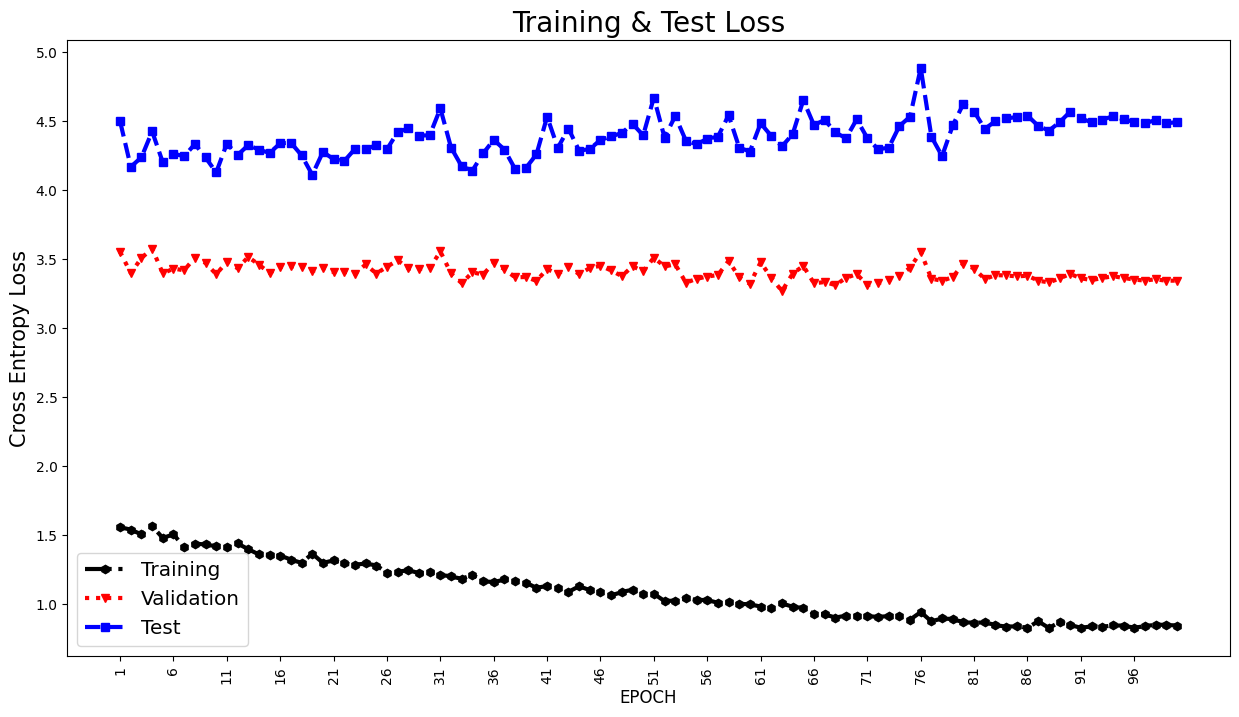

In [37]:
import pandas as pd
from pylab import rcParams
from matplotlib import pyplot as plt
from matplotlib import rc

EPOCH=list(range(1,len(TRAIN_LOSS)+1))
df=pd.DataFrame({"epoch":EPOCH,"train_loss":TRAIN_LOSS,"valid_loss":VALID_LOSS,"test_loss":TEST_LOSS,"train_recall":TRAIN_RECALL,\
                "valid_recall":VALID_RECALL,"test_recall":TEST_RECALL,"train_mrr":TRAIN_MRR,"valid_mrr":VALID_MRR,"test_mrr":TEST_MRR})

df.drop_duplicates(subset=["epoch"],inplace=True)
df.sort_values(by=['epoch'],inplace=True)

plt.rcParams["figure.figsize"] = (15,8)

plt.plot([int(x) for x in df["epoch"]],  df["train_loss"], label = "Training",color='k',marker='h', linestyle="-.", linewidth=3)
plt.plot([int(x) for x in df["epoch"]],  df["valid_loss"], label = "Validation",color='r',marker='v', linestyle=":", linewidth=3)
plt.plot([int(x) for x in df["epoch"]],  df["test_loss"], label = "Test",color='b',marker='s', linestyle="--", linewidth=3)
# plt.axvline(x=8, color='b')
plt.legend(fontsize="x-large")
plt.title("Training & Test Loss",fontsize=20)
plt.ylabel("Cross Entropy Loss",fontsize=15)
plt.xlabel("EPOCH",fontsize=12)
plt.xticks(rotation=90)
plt.xticks(np.arange(1, 101, 5))
plt.show()

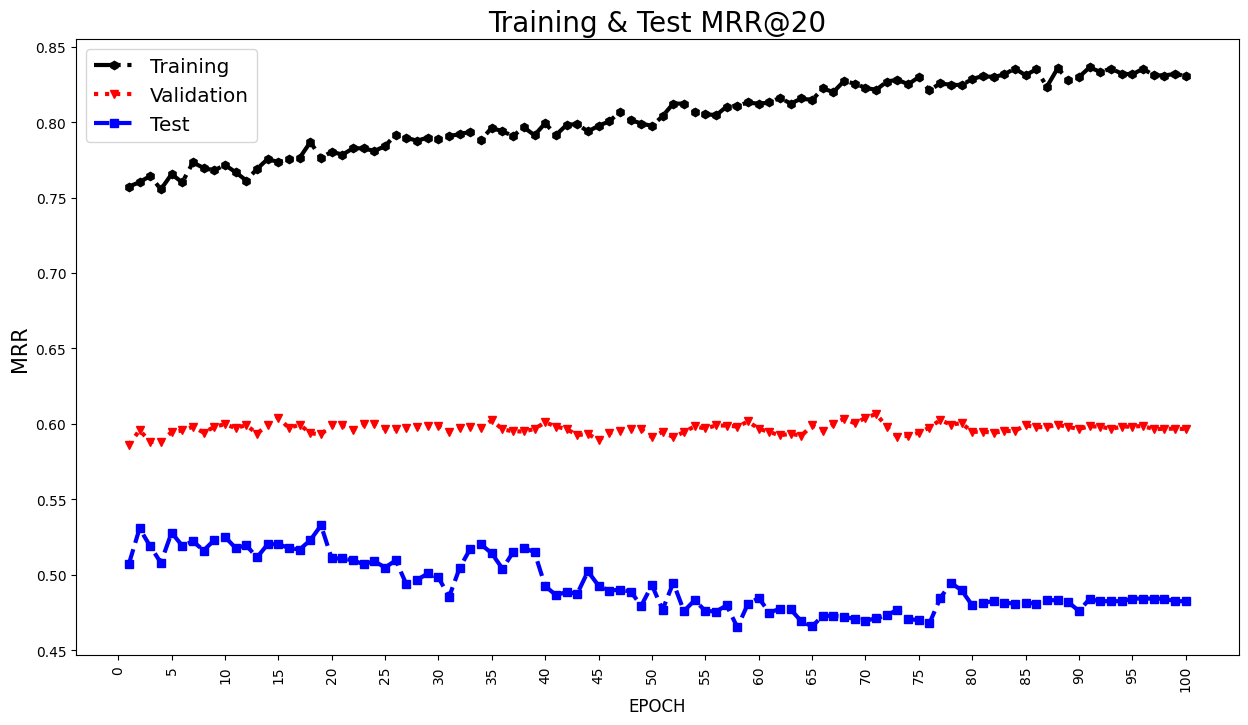

In [36]:
plt.rcParams["figure.figsize"] = (15,8)

plt.plot([int(x) for x in df["epoch"]],  df["train_mrr"], label = "Training",color='k',marker='h', linestyle="-.", linewidth=3)
plt.plot([int(x) for x in df["epoch"]],  df["valid_mrr"], label = "Validation",color='r',marker='v', linestyle=":", linewidth=3)
plt.plot([int(x) for x in df["epoch"]],  df["test_mrr"], label = "Test",color='b',marker='s', linestyle="--", linewidth=3)
# plt.axvline(x=8, color='b')
plt.legend(fontsize="x-large")
plt.title("Training & Test MRR@20",fontsize=20)
plt.ylabel("MRR",fontsize=15)
plt.xlabel("EPOCH",fontsize=12)
plt.xticks(rotation=90)
plt.xticks(np.arange(0, 101, 5))
plt.show()